<a href="https://colab.research.google.com/github/VMBoehm/DeNoPa/blob/master/MNISTInpainting_annealing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
from google.colab import drive

ROOT = "/content/gdrive"
drive.mount(ROOT, force_remount=True)

Mounted at /content/gdrive


In [3]:
! pip install -q https://github.com/dfm/corner.py/archive/master.zip

     \ 10.9MB 12.1MB/s


In [0]:
import corner

In [5]:
import tensorflow as tf
import tensorflow_probability as tfp
import tensorflow_hub as hub
tfd = tfp.distributions
tfb = tfp.bijectors
IMAGE_SHAPE = [28, 28, 1]

W0516 19:12:42.121882 139644566660992 __init__.py:56] Some hub symbols are not available because TensorFlow version is less than 1.14



For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.



In [6]:
generator_path   = './gdrive/My Drive/MPM/modules/gauss3b/gauss3b-final/decoder'
encoder_path     = './gdrive/My Drive/MPM/modules/gauss3b/gauss3b-final/encoder'
nvp_func_path    = './gdrive/My Drive/MPM/modules/gauss3b/nvp-final4'
minima_path      = './gdrive/My Drive/MPM/modules/gauss3b/minima/'
plot_path        = './gdrive/My Drive/MPM/modules/gauss3b/plots/'
!ls ./gdrive/My\ Drive/MPM/modules/gauss3b/nvp-final4/

assets	saved_model.pb	tfhub_module.pb  variables


In [0]:

from tensorflow.contrib.opt import ScipyOptimizerInterface
from tensorflow.contrib.distributions import softplus_inverse

In [0]:
import gzip, zipfile, tarfile
import os, shutil, re, string, urllib, fnmatch
import pickle as pkl

def _download_mnist_realval(dataset):
    """
    Download the MNIST dataset if it is not present.
    :return: The train, test and validation set.
    """
    origin = (
        'http://www.iro.umontreal.ca/~lisa/deep/data/mnist/mnist.pkl.gz'
    )
    print('Downloading data from %s' % origin)
    urllib.request.urlretrieve(origin, dataset)

def _get_datafolder_path():
    full_path = os.path.abspath('.')
    path = full_path +'/data'
    return path

def load_mnist_realval(
        dataset=_get_datafolder_path()+'/mnist_real/mnist.pkl.gz'):
    '''
    Loads the real valued MNIST dataset
    :param dataset: path to dataset file
    :return: None
    '''
    if not os.path.isfile(dataset):
        datasetfolder = os.path.dirname(dataset)
        if not os.path.exists(datasetfolder):
            os.makedirs(datasetfolder)
        _download_mnist_realval(dataset)

    f = gzip.open(dataset, 'rb')
    train_set, valid_set, test_set = pkl.load(f, encoding='latin1')
    f.close()
    x_train, targets_train = train_set[0], train_set[1]
    x_valid, targets_valid = valid_set[0], valid_set[1]
    x_test, targets_test = test_set[0], test_set[1]
    return x_train, targets_train, x_valid, targets_valid, x_test, targets_test

In [0]:
x_train, targets_train, x_valid, targets_valid, x_test, targets_test = load_mnist_realval()

In [254]:
#finding EL2O 'by hand'
tf.reset_default_graph()


batch_size  = 64
hidden_size = 10
sigma_n     = 0.1
n_channels  = 1
data_dim    = 28*28

sample_size_z = 64
lr            = tf.placeholder_with_default(0.001,shape=[])

encoder       = hub.Module(encoder_path, trainable=False)
generator     = hub.Module(generator_path, trainable=False)
optimizer     = tf.train.AdamOptimizer(learning_rate=lr)
grad_opt      = tf.train.GradientDescentOptimizer(learning_rate=lr)

def get_prior():
  return tfd.MultivariateNormalDiag(tf.zeros(hidden_size), scale_identity_multiplier=1.0, name ='prior')

prior = get_prior()

# ----------------------------------------------------------#


# uncorrupted data

prior_samples = tf.placeholder(shape=[sample_size_z,hidden_size], dtype=tf.float32)

x_tr          = tf.placeholder(shape=[batch_size,data_dim,n_channels], dtype=tf.float32)

encoded_data  = encoder(tf.reshape(x_tr,[-1,28,28,n_channels]))
mu, sigma     = tf.split(encoded_data, 2, axis=-1)
sigma         = tf.nn.softplus(sigma) + 0.0001

approx_posterior_vae = tfd.MultivariateNormalDiag(loc=mu, scale_diag=sigma)

vae_liklogits     = tf.reshape(generator(mu),[-1,data_dim,1])

# uncoruppted data likelihood
likelihood_vae    = tfd.Independent(tfd.MultivariateNormalDiag(loc=vae_liklogits,scale_identity_multiplier=sigma_n))
recon             = likelihood_vae.mean()

#test sample from prior
prior_sample      = prior.sample(sample_size_z)
sample_liklogits  = tf.reshape(generator(prior_samples),[-1,data_dim,n_channels])

sample_likelihood = tfd.Independent(tfd.MultivariateNormalDiag(loc=sample_liklogits,scale_identity_multiplier=sigma_n))
sample_mean       = sample_likelihood.mean()

# ----------------------------------------------------------#



# -----------train NVP ----------------------#

# nvp_size      = [[512, 512], [512, 512], [512, 512],[512, 512], [512, 512],[512, 512]]
# 

# def get_nvp():
  
#   p1 = np.arange(0,hidden_size//2)
#   p2 = np.arange(hidden_size//2,hidden_size)
#   perm=np.concatenate((p2,p1))
  
#   base_dis = get_prior()
  
#   chain = []
  
#   for i,s in enumerate(nvp_size):
#     chain.append(tfb.RealNVP(num_masked=5,shift_and_log_scale_fn=tfb.real_nvp_default_template(hidden_layers=s,name='nvp%d'%i)))
#     chain.append(tfb.Permute(permutation=perm,name='perm%d'%i))

#   nvp = tfd.TransformedDistribution(distribution=base_dis,bijector=tfb.Chain(chain),name='mynvp')
                 
#   return nvp

# def nvp_module_spec():
#     z_sample     = tf.placeholder(tf.float32, shape=[None,hidden_size])
#     sample_size  = tf.placeholder(tf.int32, shape=[])
#     u_sample     = tf.placeholder(tf.float32, shape=[None,hidden_size])
#     nvp_         = get_nvp()
#     log_prob     = nvp_.log_prob(z_sample)
#     nvp_sample   = nvp_.sample(sample_size)
#     nvp_fwd_pass = nvp_.bijector.forward(u_sample)
#     hub.add_signature(inputs={'z_sample':z_sample,'sample_size':sample_size, 'u_sample':u_sample},outputs={'log_prob':log_prob, 'sample':nvp_sample, 'fwd_pass': nvp_fwd_pass})

# nvp_spec  = hub.create_module_spec(nvp_module_spec)
# nvp_funcs = hub.Module(nvp_spec, name='nvp_funcs',trainable=True)

# nvp       = get_nvp()
# loss      = -tf.reduce_mean(nvp_funcs({'z_sample':approx_posterior_vae.sample(),'sample_size':1, 'u_sample':np.zeros((1,hidden_size))},as_dict=True)['log_prob'])

# opt_op_nvp= optimizer.minimize(loss)

# -----------train NVP ----------------------#


#load NVP 
nvp_funcs     = hub.Module(nvp_func_path, trainable=False)


nvp_prior     = tf.placeholder_with_default(True,shape=[])

# ------------------- corrupted data -------------------#

# for corrupted data
batch_size2   = 1
sigma_corr    = tf.placeholder_with_default(np.ones([batch_size2,data_dim,n_channels], dtype='float32')*sigma_n,shape=[batch_size2,784,n_channels])
x_corr        = tf.placeholder(shape=[batch_size2,data_dim,n_channels], dtype=tf.float32)

# encoded truth
x_ul          = tf.placeholder(shape=[batch_size2,data_dim,n_channels], dtype=tf.float32)

encoded_x     = encoder(tf.reshape(x_ul,[-1,28,28,n_channels]))
mu_x, sigma_x = tf.split(encoded_x, 2, axis=-1)



# ------- mean field VI on corrupted data ---------------#
with tf.variable_scope("posterior_elbo"):
  mu_elbo      = tf.Variable(np.zeros((batch_size2,hidden_size)), dtype=np.float32)
  sigma_elbo   = tf.Variable(np.ones((batch_size2,hidden_size)), dtype=np.float32)
sigma_elbo_    = tf.nn.softplus(sigma_elbo) + 0.0001

approx_posterior_elbo = tfd.MultivariateNormalDiag(loc=mu_elbo,scale_diag=sigma_elbo_, name='approxposterior_elbo')

kl_divergence     = tfd.kl_divergence(approx_posterior_elbo, prior) 
zz_               = approx_posterior_elbo.sample()
fwd_zz_           = tf.cond(nvp_prior, lambda: nvp_funcs({'z_sample':np.zeros((1,hidden_size)),'sample_size':1, 'u_sample':zz_},as_dict=True)['fwd_pass'], lambda: zz_)
elbo_liklogits    = tf.reshape(generator(fwd_zz_),[-1,data_dim,n_channels])
corr_likelihood   = tfd.Independent(tfd.MultivariateNormalDiag(loc=elbo_liklogits,scale_diag=sigma_corr))
elbo              = -tf.reduce_mean(corr_likelihood.log_prob(x_corr)- kl_divergence,axis=0)

opt_op_elbo       = optimizer.minimize(elbo,var_list=[mu_elbo,sigma_elbo])

mu_elbo_              = tf.cond(nvp_prior, lambda: nvp_funcs({'z_sample':np.zeros((1,hidden_size)),'sample_size':1, 'u_sample':mu_elbo},as_dict=True)['fwd_pass'], lambda: mu_elbo)
mu_liklogits          = tf.reshape(generator(mu_elbo_),[-1,data_dim,n_channels])
mean_corr_likelihood  = tfd.Independent(tfd.MultivariateNormalDiag(loc=mu_liklogits,scale_diag=sigma_corr)).mean()

samples_post_elbo     = tf.reshape(approx_posterior_elbo.sample(sample_size_z),[-1,hidden_size])
samples_post_elbo     = tf.cond(nvp_prior, lambda: nvp_funcs({'z_sample':np.zeros((1,hidden_size)),'sample_size':1, 'u_sample':samples_post_elbo},as_dict=True)['fwd_pass'], lambda: samples_post_elbo)
sample_elbo_liklogits = tf.reshape(generator(tf.reshape(samples_post_elbo,[batch_size2*sample_size_z,hidden_size])),[batch_size2, sample_size_z, data_dim, n_channels])
sample_elbo_mean      = tfd.Independent(tfd.MultivariateNormalDiag(loc=sample_elbo_liklogits,scale_diag=sigma_corr)).mean()

# ------- mean field VI on corrupted data ---------------#

# ------- full rank VI on corrupted data ---------------#
with tf.variable_scope("posterior_elbo_full_rank"):
  mu_f_elbo      = tf.Variable(np.zeros((batch_size2,hidden_size), dtype=np.float32), dtype=np.float32)
  sigma_f_elbo   = tf.Variable(np.ones((batch_size2,(hidden_size *(hidden_size +1)) // 2),dtype=np.float32), dtype=tf.float32)

sigma_f_elbo_t = tfd.matrix_diag_transform(tfd.fill_triangular(sigma_f_elbo), transform=tf.nn.softplus)

approx_posterior_f_elbo = tfd.MultivariateNormalTriL(loc=mu_f_elbo,scale_tril=sigma_f_elbo_t)


kl_divergence_f    = tfd.kl_divergence(approx_posterior_f_elbo, prior) 
zz_f               = approx_posterior_f_elbo.sample()
fwd_zz_f           = tf.cond(nvp_prior, lambda: nvp_funcs({'z_sample':np.zeros((1,hidden_size)),'sample_size':1, 'u_sample':zz_f},as_dict=True)['fwd_pass'], lambda: zz_f)
elbo_liklogits_f   = tf.reshape(generator(fwd_zz_f),[-1,data_dim,n_channels])
corr_likelihood_f  = tfd.Independent(tfd.MultivariateNormalDiag(loc=elbo_liklogits_f,scale_diag=sigma_corr))
elbo_f             = -tf.reduce_mean(corr_likelihood_f.log_prob(x_corr)- kl_divergence_f,axis=0)

opt_op_elbo_f      = optimizer.minimize(elbo_f,var_list=[mu_f_elbo,sigma_f_elbo])

# likelihood of posterior mean
mu_elbo_f_             = tf.cond(nvp_prior, lambda: nvp_funcs({'z_sample':np.zeros((1,hidden_size)),'sample_size':1, 'u_sample':mu_f_elbo},as_dict=True)['fwd_pass'], lambda: mu_f_elbo)
mu_f_liklogits         = tf.reshape(generator(mu_elbo_f_),[-1,data_dim,n_channels])
mean_corr_likelihood_f = tfd.Independent(tfd.MultivariateNormalDiag(loc=mu_f_liklogits,scale_diag=sigma_corr)).mean()
sample_post_elbo_f     = tf.reshape(approx_posterior_f_elbo.sample(sample_size_z),[-1,hidden_size])
sample_post_elbo_f     = tf.cond(nvp_prior, lambda: nvp_funcs({'z_sample':np.zeros((1,hidden_size)),'sample_size':1, 'u_sample':sample_post_elbo_f},as_dict=True)['fwd_pass'], lambda: sample_post_elbo_f)
sample_elbo_liklogits_f= tf.reshape(generator(tf.reshape(sample_post_elbo_f,[batch_size2*sample_size_z,hidden_size])),[batch_size2, sample_size_z, data_dim, n_channels])
sample_elbo_mean_f     = tfd.Independent(tfd.MultivariateNormalDiag(loc=sample_elbo_liklogits_f,scale_diag=sigma_corr)).mean()

# ------- full rank VI on corrupted data ---------------#



#### for naive recon and strating MAP finding at truth

inverse_T            = tf.placeholder_with_default(1., shape=[])
### estimate the MAP for ###
MAP_ini              = tf.placeholder_with_default(tf.zeros([batch_size2,hidden_size]),shape=[batch_size2,hidden_size])
MAP                  = tf.Variable(MAP_ini)

MAP_reset            = tf.stop_gradient(MAP.assign(MAP_ini))

fwd_MAP              = nvp_funcs({'z_sample':np.zeros((1,hidden_size)),'sample_size':1, 'u_sample':MAP},as_dict=True)['fwd_pass']

# option to use uncorrected latent space
genMAP               = tf.reshape(tf.cond(nvp_prior, lambda: generator(fwd_MAP), lambda: generator(MAP)),[batch_size2,data_dim,n_channels])

likeli_MAP           = tfd.Independent(tfd.MultivariateNormalDiag(loc=genMAP,scale_diag=sigma_corr))

likeli_log_prob      = likeli_MAP.log_prob(x_corr)*inverse_T

prior_MAP            = prior.log_prob(MAP)

posterior_MAP        = prior_MAP+likeli_log_prob

loss_MAP             = -tf.reduce_mean(posterior_MAP)

opt_op_MAP           = optimizer.minimize(loss_MAP, var_list=[MAP])

opt_BFGS             = ScipyOptimizerInterface(loss_MAP,method='BFGS')
opt_trust            = ScipyOptimizerInterface(loss_MAP,method='trust-exact')
opt_CG               = ScipyOptimizerInterface(loss_MAP,method='CG')

##### ----------  do Laplace approximation ----------- #####
true_hess  = tf.placeholder_with_default(True,shape=[])
diag_hess  = tf.placeholder_with_default(False,shape=[])


ini_val  = np.ones((batch_size2,(hidden_size *(hidden_size +1)) // 2),dtype=np.float64)
with tf.variable_scope("approxposterior",reuse=tf.AUTO_REUSE):
  mu_new      = tf.Variable(np.ones((batch_size2,hidden_size),dtype=np.float32), dtype=np.float64)
  sigma_new_t = ini_val
  sigma_new_t2= tf.Variable(tfd.matrix_diag_transform(tfd.fill_triangular(sigma_new_t), transform=tf.nn.softplus),dtype=tf.float64)
  
approx_posterior_laplace = tfd.MultivariateNormalTriL(loc=mu_new,scale_tril=sigma_new_t2)


# this is exact hessian computation 
hess             = tf.hessians(-posterior_MAP,MAP)
hess             = tf.gather(hess, 0)
hess2            = tf.reduce_sum(hess, axis = 2 )

# constructing Hessian from known analytic form of posterior (this is for Gaussian likelihood+prior with unit variance)

grad_g           = tf.gather(tf.gradients(genMAP/(sigma_corr),MAP),0)

grad_g2          = tf.einsum('ij,ik->ijk',grad_g,grad_g)

one              = tf.linalg.eye(hidden_size, batch_shape=[batch_size2],dtype=tf.float32)

hess_approx      = one+grad_g2

eig1             = tf.cond(true_hess, lambda: tf.linalg.eigvalsh(hess2), lambda: tf.linalg.eigvalsh(hess_approx))

sigma_hess       = tf.cond(true_hess, lambda: tf.linalg.inv(tf.cast(hess2,tf.float64)), lambda: tf.linalg.inv(tf.cast(hess_approx,tf.float64)))

scale            = tf.placeholder_with_default(1.,shape=[])

#allow for cooling
sigma_hess       = 0.5*(sigma_hess+tf.linalg.transpose(sigma_hess))*tf.cast(scale, tf.float64)

# try taking only the diagonal
sigma_diag       = tf.expand_dims(tf.linalg.tensor_diag(tf.linalg.diag_part(sigma_hess[0])),0)

eig2             = tf.linalg.eigvalsh(sigma_hess)

sigma_hess_      = tf.cond(diag_hess, lambda: tf.linalg.cholesky(sigma_diag), lambda: tf.linalg.cholesky(sigma_hess))

MAP_             = tf.cast(MAP, tf.float64)
update2          = mu_new.assign(MAP_)
update3          = sigma_new_t2.assign(sigma_hess_)

log_det          = tf.linalg.logdet(approx_posterior_laplace.covariance())

# evaluation
lap_z_samples     = tf.cast(tf.reshape(approx_posterior_laplace.sample(sample_size_z),[-1,hidden_size]),dtype=tf.float32)
fwd_zs            = tf.cond(nvp_prior,lambda: nvp_funcs({'z_sample':np.zeros((1,hidden_size)),'sample_size':1, 'u_sample':lap_z_samples},as_dict=True)['fwd_pass'], lambda:lap_z_samples) 
lap_liklogits     = tf.reshape(generator(fwd_zs),[-1,784,n_channels])
lap_likelihood    = tfd.Independent(tfd.MultivariateNormalDiag(loc=lap_liklogits,scale_diag=sigma_corr))
lap_mean          = lap_likelihood.mean()
lapl_variance_MAP = tf.linalg.diag_part(approx_posterior_laplace.covariance())

# minimize elbo with mu fixed at MAP, make sure nvp prior is set correctly
update4           = mu_elbo.assign(MAP_ini)
opt_op_elbo2      = optimizer.minimize(elbo,var_list=[sigma_elbo])


# minimize elbo_f with mu fixed at MAP, make sure nvp prior is set correctly
update5           = mu_f_elbo.assign(MAP_ini)
opt_op_elbo2f     = optimizer.minimize(elbo_f,var_list=[sigma_f_elbo])

num_chains =20

def unnormalized_log_prob(x):
  
  fwd_x              = nvp_funcs({'z_sample':np.zeros((1,hidden_size)),'sample_size':1, 'u_sample':x},as_dict=True)['fwd_pass']

  # option to use uncorrected latent space
  gen_x              = tf.reshape(tf.cond(nvp_prior, lambda: generator(fwd_x), lambda: generator(x)),[num_chains,data_dim,n_channels])

  likeli_x           = tfd.Independent(tfd.MultivariateNormalDiag(loc=gen_x,scale_diag=sigma_corr))

  likeli_log_prob_x  = likeli_x.log_prob(x_corr)

  prior_x            = prior.log_prob(x)

  posterior_x        = prior_x+likeli_log_prob_x

  return posterior_x


#### ----- this is an hmc sampler------------#

# Create state to hold updated `step_size`.
step_size = tf.get_variable(
    name='step_size',
    initializer=np.ones((num_chains,hidden_size),dtype=np.float32)*1.,
    use_resource=True,  # For TFE compatibility.
    trainable=False)



ini_chain = tf.cast(np.asarray(np.ones((hidden_size,num_chains),dtype=np.float32)*np.linspace(0,1,num_chains)).T, tf.float32)
# Initialize the HMC transition kernel.
num_results      = int(2e4)
num_burnin_steps = int(2e3)

hmc = tfp.mcmc.HamiltonianMonteCarlo(
    target_log_prob_fn=unnormalized_log_prob,
    num_leapfrog_steps=3,
    step_size=step_size,
    step_size_update_fn=tfp.mcmc.make_simple_step_size_update_policy(
      num_adaptation_steps=int(num_burnin_steps * 0.8)))

# Run the chain (with burn-in).
hmc_samples, hmc_kernel_results = tfp.mcmc.sample_chain(
    num_results=num_results,
    num_steps_between_results=10,
    num_burnin_steps=num_burnin_steps,
    current_state=ini_chain,
    kernel=hmc)
#### ----- this is an hmc sampler------------#

#### ----- this is a a Random Walk Metropolis Hastings------------#

# Initial state of the chain
init_state = tf.cast(np.asarray(np.ones((hidden_size,num_chains),dtype=np.float32)*np.linspace(0,1,num_chains)).T, tf.float32)

# Run Random Walk Metropolis with normal proposal for `num_results`
# iterations for `num_chains` independent chains:
mcmc_samples, mcmc_stats = tfp.mcmc.sample_chain(
    num_results=num_results,
    current_state=init_state,
    kernel=tfp.mcmc.RandomWalkMetropolis(
        target_log_prob_fn=unnormalized_log_prob,
        seed=54,
        new_state_fn=tfp.mcmc.random_walk_normal_fn(scale=0.1,name=None)),
    num_burnin_steps=num_burnin_steps,
    num_steps_between_results=10,  # Thinning.
    parallel_iterations=1)


# # # construct a GMM approximation from different minima
num_comp = 2

ini_val2    = np.ones((batch_size2,num_comp,(hidden_size *(hidden_size +1)) // 2),dtype=np.float32)
with tf.variable_scope("corrupted/gmm",reuse=tf.AUTO_REUSE):
  mu_gmm      = tf.Variable(np.ones((batch_size2,num_comp,hidden_size)), dtype=np.float32)
  sigma_gmm   = tf.Variable(tfd.fill_triangular(ini_val2))
  w_gmm       = tf.Variable(np.ones((num_comp))/num_comp, dtype=np.float32)
  
sigma_gmmt    = tf.Variable(tfd.matrix_diag_transform(sigma_gmm, transform=tf.nn.softplus))

mu_est        = tf.placeholder_with_default(tf.zeros([batch_size2,num_comp,hidden_size]),shape=[batch_size2,num_comp,hidden_size])
sigma_est     = tf.placeholder_with_default(tf.ones([batch_size2,num_comp,hidden_size, hidden_size]),shape=[batch_size2,num_comp,hidden_size, hidden_size])
w_est         = tf.placeholder_with_default(tf.ones([num_comp])/num_comp,shape=[num_comp])

update_a      = tf.stop_gradient(w_gmm.assign(w_est))
update_b      = tf.stop_gradient(mu_gmm.assign(mu_est))
update_c      = tf.stop_gradient(sigma_gmmt.assign(sigma_est))
update_d      = tf.stop_gradient(sigma_gmm.assign(tfd.matrix_diag_transform(sigma_gmm, transform=softplus_inverse)))

gmm           = tfd.MixtureSameFamily(mixture_distribution=tfd.Categorical(probs=w_gmm),components_distribution=tfd.MultivariateNormalTriL(loc=mu_gmm,scale_tril=sigma_gmmt))

gmm_sample_z  = tf.squeeze(gmm.sample(sample_size_z))
gmm_fwd       = tf.cond(nvp_prior,lambda: nvp_funcs({'z_sample':np.zeros((1,hidden_size)),'sample_size':1, 'u_sample':gmm_sample_z},as_dict=True)['fwd_pass'], lambda:gmm_sample_z)
gmm_fwd       = tf.reshape(generator(gmm_fwd),[-1,data_dim,1])
gmm_sample_x  = tfd.Independent(tfd.MultivariateNormalDiag(loc=gmm_fwd,scale_diag=sigma_corr)).mean()

#### optimize on GMM using EL20

gmm_sample    = tf.identity(gmm.sample())
fwd_sample    = nvp_funcs({'z_sample':np.zeros((1,hidden_size)),'sample_size':1, 'u_sample':gmm_sample},as_dict=True)['fwd_pass']

# option to use uncorrected latent space
gen_z         = tf.reshape(tf.cond(nvp_prior, lambda: generator(fwd_sample), lambda: generator(gmm_sample)),[batch_size2,data_dim,n_channels])

likeli_z      = tfd.Independent(tfd.MultivariateNormalDiag(loc=gen_z,scale_diag=sigma_corr))

likeli_log_prob_z = likeli_z.log_prob(x_corr)

prior_z       = prior.log_prob(gmm_sample)

posterior_z   = -(prior_z+likeli_log_prob_z)

posterior_gmm = -gmm.log_prob(gmm_sample)

grad_gmm      = tf.gather(tf.gradients(posterior_gmm,gmm_sample),0)

grad_post     = tf.gather(tf.gradients(posterior_z,gmm_sample),0)

gradgrad_gmm  = tf.reduce_sum(tf.gather(tf.hessians(grad_gmm,gmm_sample),0),axis=2)

gradgrad_post = tf.reduce_sum(tf.gather(tf.hessians(grad_post,gmm_sample),0),axis=2)

el2o          = tf.reduce_mean(tf.square(posterior_gmm-posterior_z))+tf.reduce_mean(tf.square(grad_post-grad_gmm))+tf.reduce_mean(tf.square(gradgrad_post-gradgrad_gmm))

opt_op_el2o   = optimizer.minimize(el2o,var_list=[w_gmm, mu_gmm, sigma_gmm])


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0517 01:49:15.941201 139644566660992 saver.py:1483] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0517 01:49:15.990808 139644566660992 saver.py:1483] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0517 01:49:16.071777 139644566660992 saver.py:1483] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0517 01:49:16.653359 139644566660992 saver.py:1483] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0517 01:49:17.083204 139644566660992 saver.py:1483] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0517 01:49:17.164019 139644566660992 saver.py:1483] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0517 01:49:18.266186 139644566660992 saver.py:1483] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0517 01:49:18.363044 139644566660992 saver.py:1483] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0517 01:49:28.107510 139644566660992 saver.py:1483] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0517 01:49:28.233242 139644566660992 saver.py:1483] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0517 01:49:28.717362 139644566660992 saver.py:1483] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0517 01:49:28.838865 139644566660992 saver.py:1483] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0517 01:49:30.002712 139644566660992 saver.py:1483] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0517 01:49:30.142167 139644566660992 saver.py:1483] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0517 01:49:30.632050 139644566660992 saver.py:1483] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0517 01:49:30.774041 139644566660992 saver.py:1483] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0517 01:49:31.139516 139644566660992 saver.py:1483] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0517 01:49:31.302189 139644566660992 saver.py:1483] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0517 01:49:31.417812 139644566660992 saver.py:1483] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0517 01:49:36.322425 139644566660992 saver.py:1483] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0517 01:49:36.535272 139644566660992 saver.py:1483] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0517 01:49:39.695297 139644566660992 saver.py:1483] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0517 01:49:39.932259 139644566660992 saver.py:1483] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0517 01:49:40.111186 139644566660992 saver.py:1483] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0517 01:49:42.394830 139644566660992 saver.py:1483] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0517 01:49:42.674280 139644566660992 saver.py:1483] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0517 01:49:42.898762 139644566660992 saver.py:1483] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0517 01:49:44.542707 139644566660992 saver.py:1483] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0517 01:49:44.833230 139644566660992 saver.py:1483] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0517 01:49:45.071183 139644566660992 saver.py:1483] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0517 01:49:45.860113 139644566660992 saver.py:1483] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0517 01:49:46.165171 139644566660992 saver.py:1483] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0517 01:49:46.414480 139644566660992 saver.py:1483] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0517 01:49:47.441937 139644566660992 saver.py:1483] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0517 01:49:47.744890 139644566660992 saver.py:1483] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0517 01:49:48.371984 139644566660992 saver.py:1483] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0517 01:49:48.699377 139644566660992 saver.py:1483] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0517 01:49:48.977545 139644566660992 saver.py:1483] Saver not created because there are no variables in the graph to restore


In [0]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())

**Reconstruct uncorrupted test data and inspect samples**

In [0]:
inc     = 0
x_truth = x_test[inc:batch_size+inc]

(64, 784, 1)
(64, 784, 1)


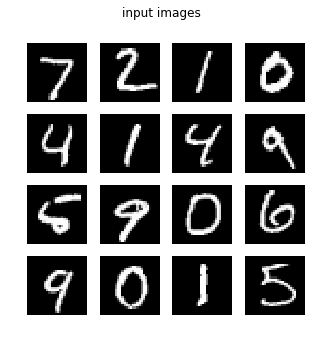

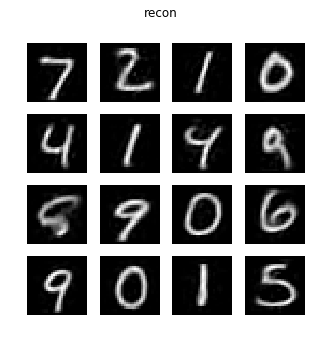

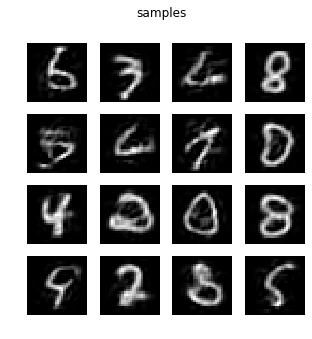

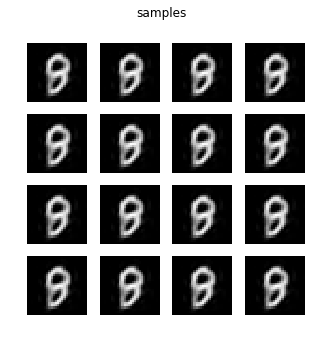

In [236]:
p_samples = sess.run(prior_sample)
rec, samples = sess.run([recon,sample_mean], feed_dict={x_tr: np.expand_dims(x_truth,-1), prior_samples: p_samples})
    
figure(figsize=(5,5))
suptitle('input images')
for i in range(min(batch_size,16)):
    subplot(4,4,i+1)
    imshow(x_truth[i].reshape((28,28)),cmap='gray',vmin=0); #colorbar()
    axis('off')

figure(figsize=(5,5))
suptitle('recon')
for i in range(min(batch_size,16)):
    subplot(4,4,i+1)
    imshow(np.reshape(rec[i,:,0],(28,28)),cmap='gray',vmin=0); #colorbar()
    axis('off')
    
print(samples.shape)
figure(figsize=(5,5))
suptitle('samples')
for i in range(min(batch_size,16)):
    subplot(4,4,i+1)
    imshow(np.reshape(samples[i,:,0],(28,28)),cmap='gray',vmin=0); #colorbar()
    axis('off')
    
p_samples = np.zeros_like(p_samples)
rec, samples = sess.run([recon,sample_mean], feed_dict={x_tr: np.expand_dims(x_truth,-1), prior_samples: p_samples})

print(samples.shape)
figure(figsize=(5,5))
suptitle('samples')
for i in range(min(batch_size,16)):
    subplot(4,4,i+1)
    imshow(np.reshape(samples[i,:,0],(28,28)),cmap='gray',vmin=0); #colorbar()
    axis('off')

**Fit NVP to posterior for better samples**

In [0]:
# nvp_loss = []
# ii     = 0
# nepoch = 0
# learning_rate = 1e-3

In [0]:
# #train the nvp
# while nepoch<1000:
#   if (ii+1)*batch_size>len(x_train): 
#     np.random.shuffle(x_train)
#     ii=0
#     nepoch+=1
#     print('starting epoch', nepoch)
#   if nepoch>10:
#     learning_rate=1e-5
#   if nepoch>200:
#     learning_rate=1e-6
#   x_truth = x_train[batch_size*ii:batch_size*(ii+1)]
#   _, ll = sess.run([opt_op_nvp,loss], feed_dict={x_tr: np.expand_dims(x_truth,-1), lr: learning_rate})
#   nvp_loss+=[ll]
#   if ii%500==0:
#     print(ll)
#   ii+=1

In [0]:
# plt.figure()
# plot(nvp_loss[::],label='nvp loss')
# legend()

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0516 05:05:08.029361 140614245906304 saver.py:1483] Saver not created because there are no variables in the graph to restore


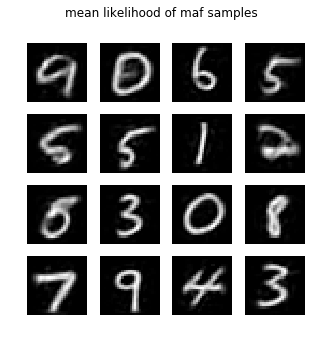

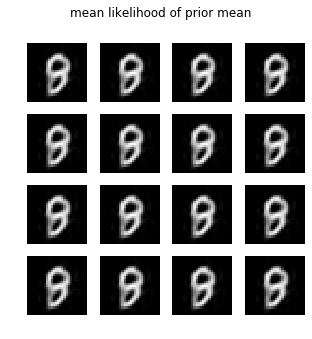

In [29]:
samples1 = sess.run(nvp_funcs({'z_sample':approx_posterior_vae.sample(),'sample_size':sample_size_z,'u_sample':np.zeros((1, hidden_size))},as_dict=True)['sample'])

s = sess.run(sample_mean, feed_dict={prior_samples: samples1})

figure(figsize=(5,5))
suptitle('mean likelihood of maf samples')
for i in range(16):
    subplot(4,4,i+1)
    imshow(np.reshape(s[i,:,0],(28,28)),cmap='gray',vmin=0); #colorbar()
    axis('off')
    
    
s = sess.run(sample_mean, feed_dict={prior_samples: np.zeros_like(samples1)})

figure(figsize=(5,5))
suptitle('mean likelihood of prior mean')
for i in range(16):
    subplot(4,4,i+1)
    imshow(np.reshape(s[i,:,0],(28,28)),cmap='gray',vmin=0); #colorbar()
    axis('off')

In [0]:

#nvp_funcs.export(nvp_func_path,sess)


In [13]:
maf_s, prior_s = sess.run([nvp_funcs({'z_sample':approx_posterior_vae.sample(),'sample_size':10000,'u_sample':np.zeros((1, hidden_size))},as_dict=True)['sample'], prior.sample(10000)])
print(maf_s.shape)

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0514 04:53:53.923635 139941427271552 saver.py:1483] Saver not created because there are no variables in the graph to restore


(10000, 10)


/usr/local/lib/python3.6/dist-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


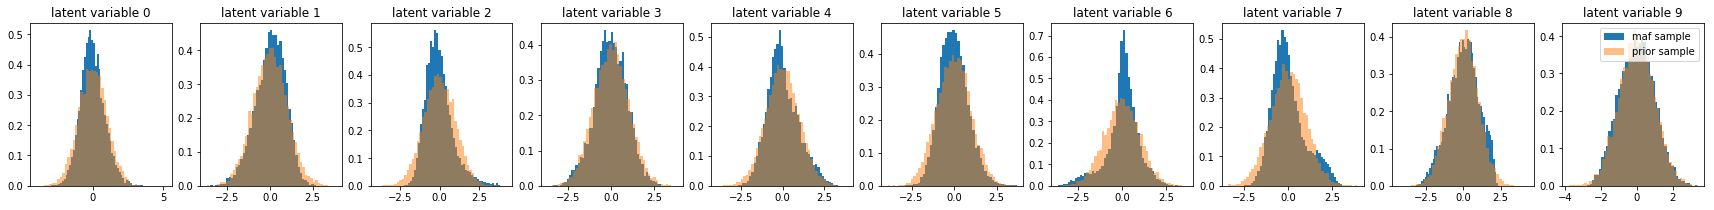

In [14]:
f=plt.figure()
f.set_figheight(3)
f.set_figwidth(30)
for ii in range(hidden_size):
  subplot(1,hidden_size,ii+1)
  plt.title('latent variable %d'%ii)
  _=plt.hist(maf_s[:,ii],bins=50, label='maf sample',normed=True)
  _=plt.hist(prior_s[:,ii],alpha=0.5,bins=50,label='prior sample',normed=True)
plt.legend()
plt.show()

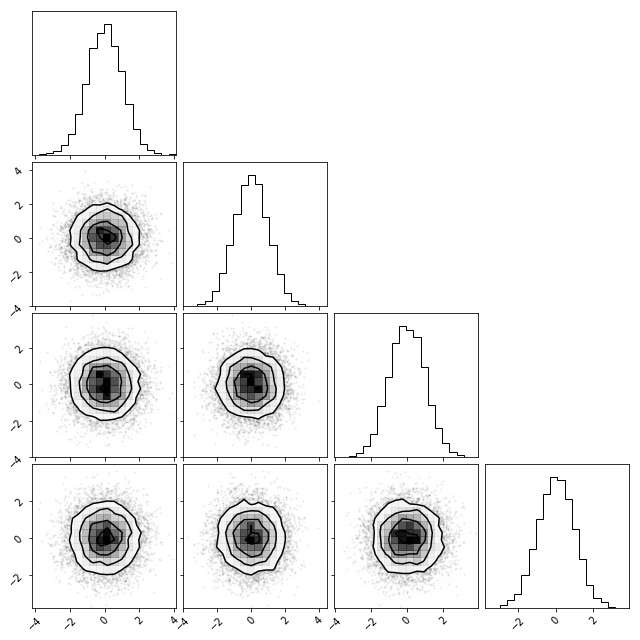

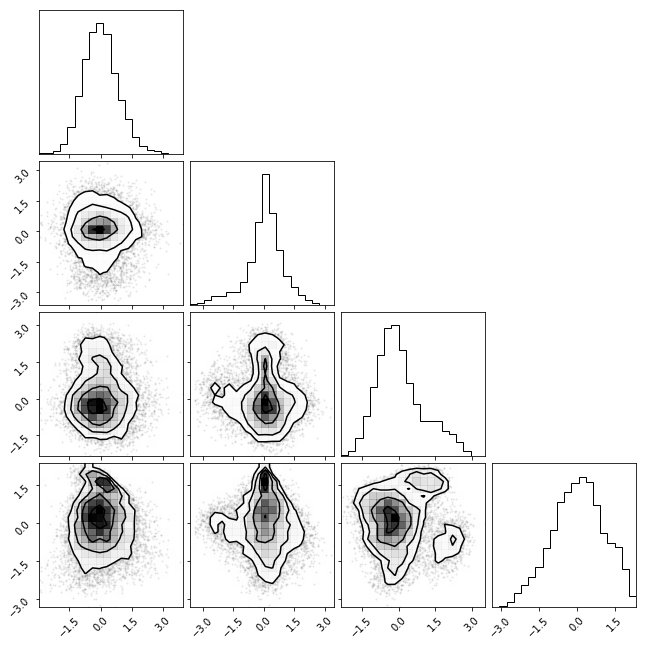

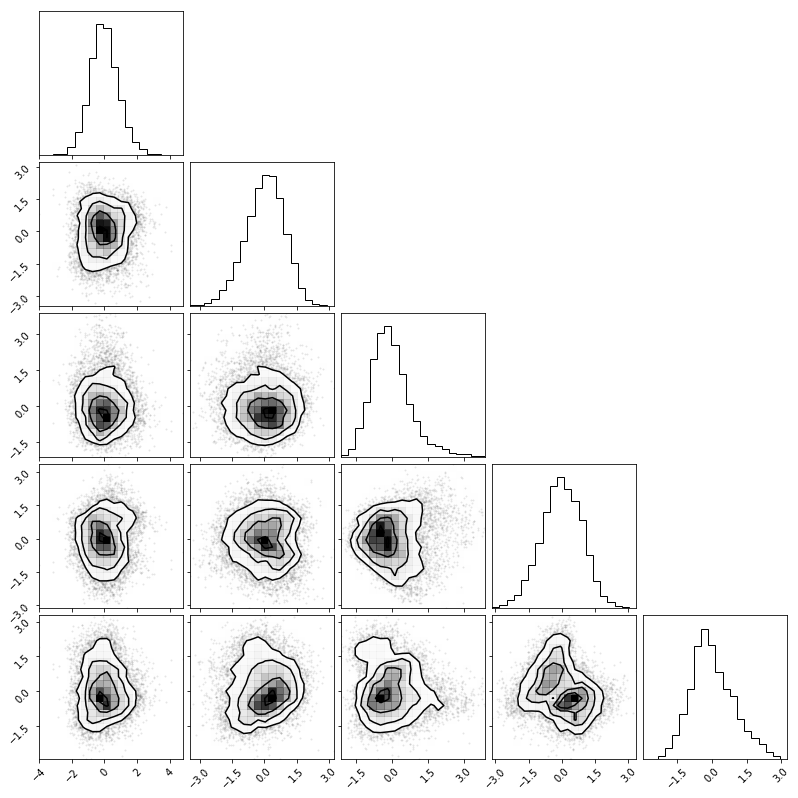

In [150]:
_ = corner.corner(prior_s[:,5:-1])
_ = corner.corner(maf_s[:,5:-1])
_ = corner.corner(maf_s[:,0:5])

**Make corrupted data**

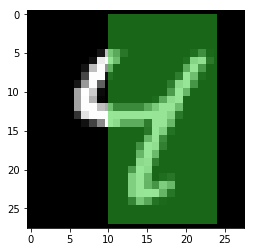

In [237]:

mask = np.ones(IMAGE_SHAPE, dtype=int)
# use also 12:18/12:20 -> 4 
minx = 10
maxx = 24
mask[0:28,minx:maxx]=0.
mask = mask.reshape((28*28))
sigma_new = np.ones(mask.shape)*sigma_n
sigma_new[np.where(mask==0)] = sigma_n*1e4
x_true = x_test[6:6+batch_size2]
masked_data = x_true*[mask]
sigma_new = np.asarray([np.expand_dims(sigma_new,-1)]*batch_size2)

data = np.expand_dims(masked_data,-1)
plt.figure()
_=plt.imshow(x_true.reshape((28,28)),cmap='gray',vmin=0)
x = np.arange(28)
plt.fill_between(x, 0, 27, where=[(x>=minx)*(x<=maxx)][0] ,facecolor='limegreen', alpha=0.5)
plt.show()


**Minimize ELBO for corrupted data and look at samples**

A) mean field

In [0]:
posterior_loss=[]

In [132]:
lrate=1e-3
for ii in range(16000):
  if ii >8000:
    lrate=1e-4
  _, ll = sess.run([opt_op_elbo, elbo],feed_dict={x_corr: np.expand_dims(masked_data,-1), lr:lrate, sigma_corr:sigma_new, nvp_prior:True})
  posterior_loss.append(ll)
  if ii%1000==0:
    print(ll)

2633.6372
2629.8215
2628.2727
2628.0662
2629.6973
2633.3845
2642.1213
2630.141
2631.8916
2630.8108
2634.5547
2640.4805
2637.6824
2632.392
2643.9277
2631.041


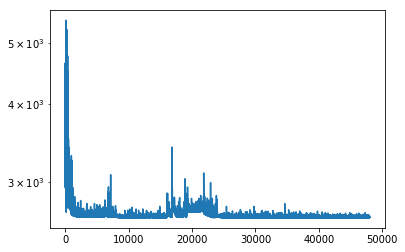

In [133]:
plt.plot(posterior_loss)
yscale('log')

In [134]:
mean    = sess.run(mean_corr_likelihood,feed_dict={x_corr: np.expand_dims(masked_data,-1), lr:lrate, sigma_corr:sigma_new, nvp_prior:True})
samples = sess.run(sample_elbo_mean,feed_dict={x_corr: np.expand_dims(masked_data,-1), lr:lrate, sigma_corr:sigma_new, nvp_prior:True})

VI_mean, VI_cov = sess.run([approx_posterior_elbo.mean(),approx_posterior_elbo.covariance()],feed_dict={x_corr: np.expand_dims(masked_data,-1), lr:lrate, sigma_corr:sigma_new, nvp_prior:True})
VI_min_loss     = sess.run(approx_posterior_elbo.log_prob(VI_mean),feed_dict={x_corr: np.expand_dims(masked_data,-1), lr:lrate, sigma_corr:sigma_new, nvp_prior:True})
VI_min_loss = - VI_min_loss
print(VI_mean,VI_min_loss)

[[ 1.5420538  -0.42289233 -0.91307974  0.8211902   0.13227974  0.9008279
   0.4744373  -3.235739    0.2653391   1.0798557 ]] [-19.203896]


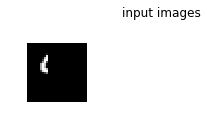

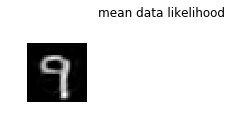

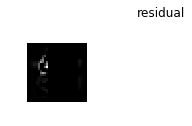

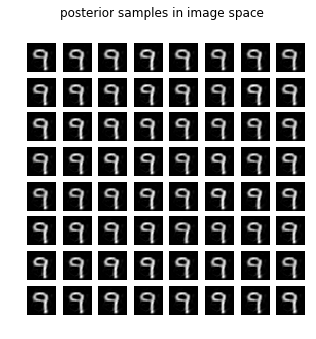

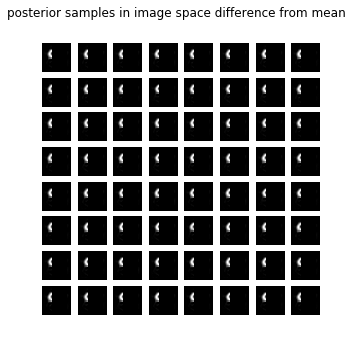

In [135]:
# try different starting values for VI?

figure(figsize=(5,5))
suptitle('input images')
for i in range(min(batch_size2,16)):
    subplot(4,4,i+1)
    imshow(masked_data[i].reshape((28,28)),cmap='gray',vmin=0); #colorbar()
    axis('off')
plt.show()
figure(figsize=(5,5))
suptitle('mean data likelihood')
for i in range(min(batch_size2,16)):
    subplot(4,4,i+1)
    imshow(np.reshape(mean[i,:,0],(28,28)),cmap='gray',vmin=0); #colorbar()
    axis('off')
plt.show()
figure(figsize=(5,5))
suptitle('residual')
for i in range(min(batch_size2,16)):
    subplot(4,4,i+1)
    imshow(np.reshape((mean[i,:,0]-data[0,:,0])*mask,(28,28)),cmap='gray',vmin=0); #colorbar()
    axis('off')
plt.show()


figure(figsize=(5,5))
suptitle('posterior samples in image space')
for i in range(min(batch_size2,16)):
    for j in range(64):
      subplot(8,8,j+1)
      imshow(np.reshape(samples[i,j,:,0],(28,28)),cmap='gray',vmin=0); #colorbar()
      axis('off')
plt.savefig(plot_path+'mfVI_samples_xmin%d_xmax%d.png'%(minx,maxx),bbox_inches='tight')
plt.show()
figure(figsize=(5,5))
suptitle('posterior samples in image space difference from mean')
for i in range(min(batch_size2,16)):
    mean_sample = np.mean(samples[i,:,:,0],axis=0)
    for j in range(64):
      subplot(8,8,j+1)
      imshow(np.reshape(samples[i,j,:,0]*mask,(28,28)),cmap='gray',vmin=0); #colorbar()
      axis('off')
plt.savefig(plot_path+'mfVImasked_samples_xmin%d_xmax%d.png'%(minx,maxx),bbox_inches='tight')
plt.show()

In [0]:
import pickle
try:
  VI_mean, VI_cov, VI_loss = pickle.load(open(minima_path+'nvp_meanfieldVI_xmin%d_xmax%d.pkl'%(minx,maxx),'rb'))
except: 
  pickle.dump([VI_mean, VI_cov, VI_min_loss],open(minima_path+'nvp_meanfieldVI_xmin%d_xmax%d.pkl'%(minx,maxx),'wb'))


B) full rank

In [0]:
posterior_loss=[]
#sess.run([reset_elbo, reset_elbo2],feed_dict={x_corr: np.expand_dims(masked_data,-1), lr:lrate, sigma_corr:sigma_new, nvp_prior:True})

In [143]:
lrate=1e-3
for ii in range(8000):
  _, ll = sess.run([opt_op_elbo_f, elbo_f],feed_dict={x_corr: np.expand_dims(masked_data,-1), lr:lrate, sigma_corr:sigma_new, nvp_prior:True})
  posterior_loss.append(ll)
  if ii%1000==0:
    print(ll)

2657.5825
2658.5762
2662.7537
2653.0906
2653.2043
2655.795
2658.9573
2664.285


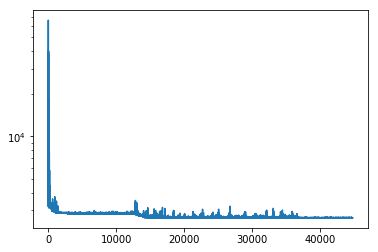

In [144]:
plt.plot(posterior_loss)
yscale('log')

In [145]:
mean   = sess.run(mean_corr_likelihood_f,feed_dict={x_corr: np.expand_dims(masked_data,-1), lr:lrate, sigma_corr:sigma_new, nvp_prior:True})
samples = sess.run(sample_elbo_mean_f,feed_dict={x_corr: np.expand_dims(masked_data,-1), lr:lrate, sigma_corr:sigma_new, nvp_prior:True})
VI_f_mean, VI_f_cov = sess.run([approx_posterior_f_elbo.mean(),approx_posterior_f_elbo.covariance()],feed_dict={x_corr: np.expand_dims(masked_data,-1), lr:lrate, sigma_corr:sigma_new, nvp_prior:True})
VI_f_min_loss = sess.run(approx_posterior_f_elbo.log_prob(VI_f_mean),feed_dict={x_corr: np.expand_dims(masked_data,-1), lr:lrate, sigma_corr:sigma_new, nvp_prior:True})
VI_f_min_loss = -VI_f_min_loss
print(VI_f_mean,VI_f_min_loss)

[[-0.64900273 -1.0745004  -1.3077915   2.6800232   0.56117857  0.9857219
  -3.762606    0.17987494  2.7829196   2.9288723 ]] [-13.17554]


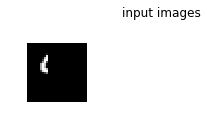

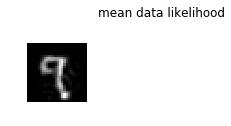

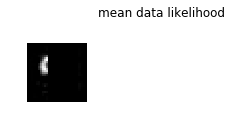

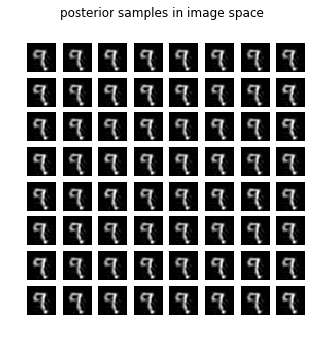

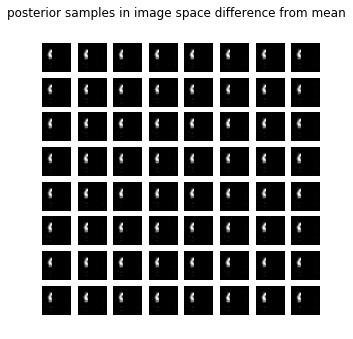

In [146]:
# try different starting values for VI?

figure(figsize=(5,5))
suptitle('input images')
for i in range(min(batch_size2,16)):
    subplot(4,4,i+1)
    imshow(masked_data[i].reshape((28,28)),cmap='gray',vmin=0); #colorbar()
    axis('off')
plt.show()
figure(figsize=(5,5))
suptitle('mean data likelihood')
for i in range(min(batch_size2,16)):
    subplot(4,4,i+1)
    imshow(np.reshape(mean[i,:,0],(28,28)),cmap='gray',vmin=0); #colorbar()
    axis('off')
plt.show()
figure(figsize=(5,5))
suptitle('mean data likelihood')
for i in range(min(batch_size2,16)):
    subplot(4,4,i+1)
    imshow(np.reshape(mean[i,:,0]*mask,(28,28)),cmap='gray',vmin=0); #colorbar()
    axis('off')
plt.show()


figure(figsize=(5,5))
suptitle('posterior samples in image space')
for i in range(min(batch_size2,16)):
    for j in range(64):
      subplot(8,8,j+1)
      imshow(np.reshape(samples[i,j,:,0],(28,28)),cmap='gray',vmin=0); #colorbar()
      axis('off')
plt.savefig(plot_path+'frfVI_samples_xmin%d_xmax%d.png'%(minx,maxx),bbox_inches='tight')

plt.show()
figure(figsize=(5,5))
suptitle('posterior samples in image space difference from mean')
for i in range(min(batch_size2,16)):
    mean_sample = np.mean(samples[i,:,:,0],axis=0)
    for j in range(64):
      subplot(8,8,j+1)
      imshow(np.reshape(samples[i,j,:,0]*mask,(28,28)),cmap='gray',vmin=0); #colorbar()
      axis('off')
plt.savefig(plot_path+'frfVI_samplesmasked_xmin%d_xmax%d.png'%(minx,maxx),bbox_inches='tight')
plt.show()

In [0]:
try:
  VI_f_mean, VI_f_cov,VI_f_min_loss = pickle.load(open(minima_path+'nvp_fullrankVI_xmin%d_xmax%d.pkl'%(minx,maxx),'rb'))
except:
  
  pickle.dump([VI_f_mean, VI_f_cov,VI_f_min_loss],open(minima_path+'nvp_fullrankVI_xmin%d_xmax%d.pkl'%(minx,maxx),'wb'))

In [186]:
np.round(np.exp(-0.5*(1.-np.arange(100)/100)), decimals=1)

array([0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6,
       0.6, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7,
       0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7,
       0.7, 0.7, 0.7, 0.7, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8,
       0.8, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8,
       0.8, 0.8, 0.8, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9,
       0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 1. ,
       1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. ])

**find minima with nvp**

0
607.99036 0.2
533.00903 0.2
530.6429 0.2
530.75665 0.2
791.5327 0.3
791.51526 0.3
791.5422 0.3
1062.3242 0.4
1061.5635 0.4
1326.15 0.5
2625.8748
2623.8564
2623.6826
2624.0854
2623.742
2623.7207
2623.6694
2623.6902
2623.8748
2623.7104
switching to lr 0.001
2623.7424
2623.6055
2623.598
2623.6077
[[-3.1289673e+00 -8.5897386e-02  2.1173615e+00  8.1186886e+00
   1.5889627e+01  5.3757034e+01  3.2009775e+02  5.6712170e+02
   3.4742297e+03  1.3625928e+04]]


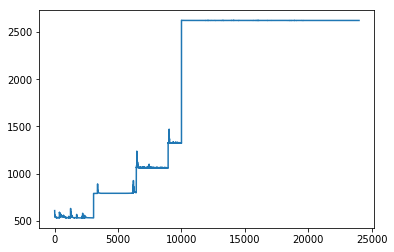

1
584.0293 0.2
532.7484 0.2
533.43396 0.2
533.014 0.2
792.33777 0.3
794.24725 0.3
792.02783 0.3
1060.8519 0.4
1067.0704 0.4
1329.4434 0.5
2635.86
2625.1824
2625.2073
2625.1648
2625.1538
2625.0366
2625.122
2625.0215
2625.0986
2625.0132
switching to lr 0.001
2625.183
2625.006
2625.0059
2625.0034
[[-5.9609280e+00  2.2543218e+00  2.5470395e+00  3.6881998e+00
   9.4693623e+00  2.2265337e+01  7.9456123e+01  1.4266422e+02
   8.0888464e+02  2.6551318e+04]]


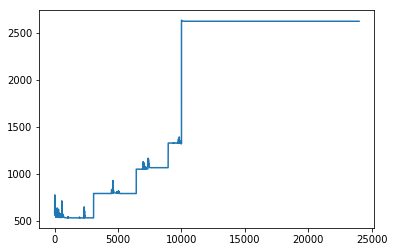

2
753.95746 0.2
532.8702 0.2
532.6281 0.2
532.66064 0.2
792.7857 0.3
793.46313 0.3
792.69855 0.3
1054.0402 0.4
1053.4391 0.4
1309.5891 0.5
2654.6216
2652.6436
2652.65
2652.677
2652.6548
2652.6309
2652.677
2652.627
2652.6296
2652.9282
switching to lr 0.001
2652.7036
2652.6108
2652.6123
2652.612
[[-1.9924010e-01  9.2375809e-01  2.8738694e+00  3.7335227e+00
   1.0371047e+01  4.3858269e+01  2.4445410e+02  3.1077124e+02
   1.5903735e+03  1.4875735e+04]]


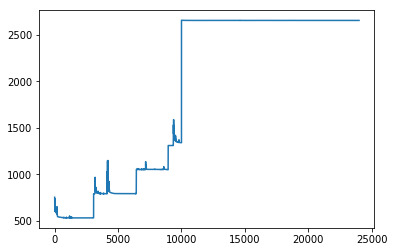

3
630.4463 0.2
537.3404 0.2
537.36505 0.2
537.2771 0.2
798.3983 0.3
797.9936 0.3
798.3797 0.3
1059.7347 0.4
1056.808 0.4
1316.2135 0.5
2611.114
2610.7874
2610.7803
2610.7754
2610.7773
2610.7803
2610.778
2610.7786
2610.784
2610.7786
switching to lr 0.001
2610.7905
2610.776
2610.7751
2610.7756
[[-3.6752990e-01  1.2696122e+00  2.1195567e+00  7.3571601e+00
   9.3989391e+00  2.2038033e+01  9.7062141e+01  2.8333032e+02
   1.2185051e+03  5.1748467e+03]]


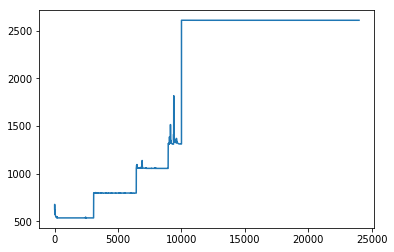

4
677.1437 0.2
532.67554 0.2
531.3231 0.2
531.3233 0.2
798.45184 0.3
797.93414 0.3
798.51245 0.3
1057.6862 0.4
1066.4188 0.4
1319.5486 0.5
2627.051
2626.2036
2625.212
2625.0188
2625.0574
2625.1294
2625.0286
2625.078
2625.0298
2625.03
switching to lr 0.001
2625.0413
2625.0144
2625.0251
2625.0166
[[4.2691800e-01 1.5703635e+00 2.1143451e+00 2.8601789e+00 6.6159997e+00
  1.1695608e+01 1.0197038e+02 1.3406503e+02 1.3699541e+03 2.7916980e+04]]


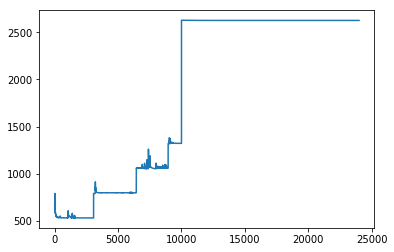

5
580.45056 0.2
531.52386 0.2
531.52527 0.2
531.5231 0.2
791.2154 0.3
791.2106 0.3
834.1266 0.3
1051.3027 0.4
1050.9003 0.4
1310.8777 0.5
2609.1946
2608.9487
2608.9448
2608.9304
2609.045
2609.0042
2608.9287
2609.0073
2608.949
2608.987
switching to lr 0.001
2608.9565
2608.9138
2608.921
2608.9165
[[1.4533565e+00 2.0101302e+00 8.2902069e+00 1.3195562e+01 3.1303087e+01
  1.1291185e+02 1.4359653e+02 5.5603003e+02 2.2069097e+03 6.5150186e+03]]


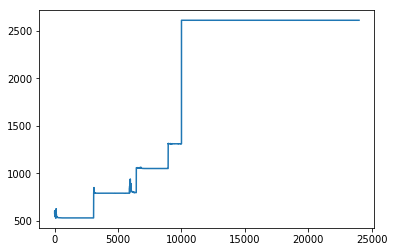

6
664.04846 0.2
670.2778 0.2
537.7394 0.2
531.4571 0.2
791.3294 0.3
791.24164 0.3
791.2856 0.3
1052.6285 0.4
1050.8688 0.4
1310.6874 0.5
2609.4436
2608.946
2608.9827
2608.962
2608.975
2608.985
2609.0994
2609.047
2608.9897
2608.966
switching to lr 0.001
2609.0137
2608.9138
2608.9185
2608.9138
[[1.6907172e+00 1.9699421e+00 9.6170263e+00 1.3625298e+01 4.0423946e+01
  8.3760330e+01 1.4931796e+02 4.6269647e+02 2.2495625e+03 6.1115850e+03]]


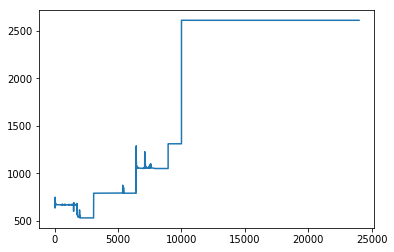

7
666.7865 0.2
538.2177 0.2
537.7288 0.2
537.5328 0.2
792.47314 0.3
792.54364 0.3
792.90173 0.3
1051.298 0.4
1051.4879 0.4
1313.7631 0.5
2610.4734
2610.0962
2610.1172
2610.1968
2610.1345
2610.1382
2610.1182
2610.0989
2610.14
2610.1714
switching to lr 0.001
2610.1323
2610.0957
2610.0916
2610.0889
[[2.43661690e+00 3.64968109e+00 6.20037460e+00 1.13319111e+01
  2.79945068e+01 1.27852715e+02 1.66651657e+02 3.09739716e+02
  5.90232910e+02 1.85862852e+04]]


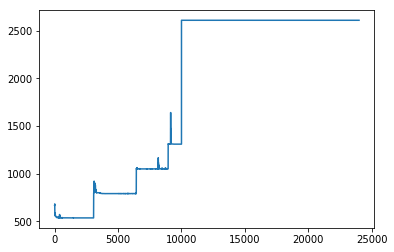

8
707.74347 0.2
531.5225 0.2
531.52435 0.2
531.523 0.2
792.9684 0.3
792.57697 0.3
791.4325 0.3
1112.1719 0.4
1072.0605 0.4
1335.2211 0.5
2615.5823
2615.308
2615.3093
2615.3088
2615.313
2615.2805
2615.2776
2615.2617
2615.329
2615.2612
switching to lr 0.001
2615.2957
2615.2588
2615.2593
2615.2583
[[-8.4197646e-01  1.3289776e+00  3.7264295e+00  6.2603941e+00
   8.2304306e+00  1.2195503e+01  1.1264580e+02  6.8823438e+02
   3.3111836e+03  8.4394629e+03]]


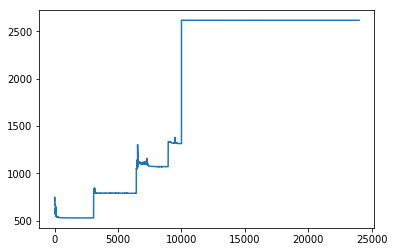

9
872.8019 0.2
533.3918 0.2
533.70337 0.2
533.0247 0.2
790.7515 0.3
790.2362 0.3
792.3511 0.3
1051.4471 0.4
1053.4878 0.4
1315.3217 0.5
2612.0771
2611.6812
2611.5706
2611.538
2611.616
2611.4966
2611.57
2611.51
2611.5586
2611.5752
switching to lr 0.001
2611.5046
2611.4644
2611.4607
2611.4622
[[1.46025372e+00 3.06758571e+00 5.85684490e+00 9.37437439e+00
  1.92986736e+01 4.25497017e+01 1.04846436e+02 4.50826965e+02
  3.58082251e+03 6.46823438e+03]]


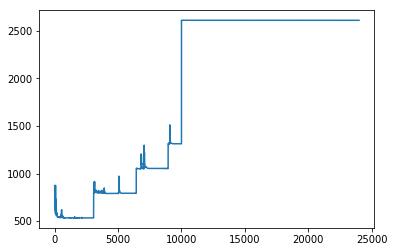

10
672.7925 0.2
532.0494 0.2
532.0877 0.2
532.0062 0.2
791.20355 0.3
790.9743 0.3
790.18445 0.3
1080.2089 0.4
1078.5013 0.4
1342.3804 0.5
2611.966
2611.7317
2611.7847
2611.7505
2611.7488
2611.7869
2611.8809
2611.9268
2611.7615
2611.7717
switching to lr 0.001
2611.7522
2611.7249
2611.7244
2611.7207
[[-2.5172610e+00  1.0146114e+00  2.0625465e+00  6.2350917e+00
   2.4377995e+01  4.7379776e+01  9.9358009e+01  6.5025690e+02
   3.5269688e+03  7.0726631e+03]]


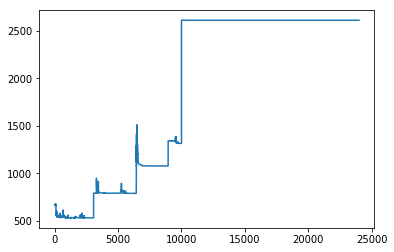

11
621.1326 0.2
531.14374 0.2
531.1492 0.2
531.19543 0.2
791.4279 0.3
791.4691 0.3
791.40686 0.3
1064.8131 0.4
1052.3685 0.4
1312.082 0.5
2609.9138
2609.423
2609.4885
2609.458
2609.4443
2609.476
2609.5793
2609.454
2609.427
2609.3616
switching to lr 0.001
2609.394
2609.3232
2609.329
2609.3328
[[1.6565976e+00 4.9564433e+00 6.3733077e+00 1.0006663e+01 1.3486968e+01
  5.8042603e+01 1.1520152e+02 2.6062918e+02 8.0160730e+02 3.6270479e+03]]


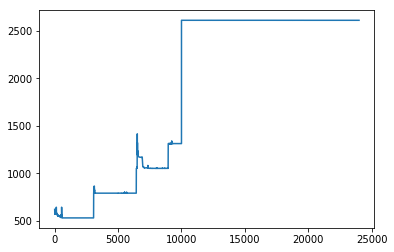

12
679.8593 0.2
576.40204 0.2
664.5762 0.2
658.9925 0.2
790.8322 0.3
790.8406 0.3
790.83856 0.3
1050.3582 0.4
1052.4132 0.4
1312.3026 0.5
2610.2568
2610.1294
2610.1135
2610.2236
2610.1194
2610.1772
2610.1917
2610.1243
2610.1335
2610.1414
switching to lr 0.001
2610.1277
2610.0933
2610.0957
2610.0952
[[1.8378361e+00 3.2471449e+00 6.1703358e+00 1.2698883e+01 2.5894390e+01
  1.3349368e+02 1.3845110e+02 3.1578091e+02 5.8486060e+02 1.8224449e+04]]


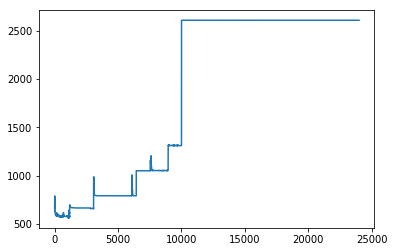

13
680.71533 0.2
530.9599 0.2
530.7565 0.2
540.22424 0.2
793.9305 0.3
793.9316 0.3
792.06775 0.3
1051.1449 0.4
1061.2394 0.4
1326.1014 0.5
2607.4578
2607.3403
2607.393
2607.4097
2607.3604
2607.3308
2607.3108
2607.33
2607.369
2607.33
switching to lr 0.001
2607.3503
2607.308
2607.3032
2607.307
[[-1.2584151e+00  1.0001888e+00  1.5354910e+00  5.8468943e+00
   2.3746841e+01  3.4501751e+01  1.6441753e+02  3.6582550e+02
   1.5310195e+03  8.3804512e+03]]


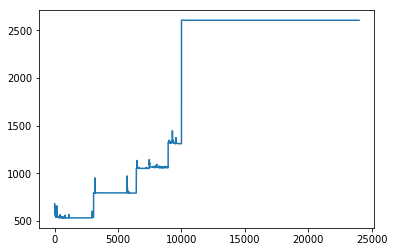

14
686.9087 0.2
668.6345 0.2
668.9622 0.2
668.8417 0.2
996.66943 0.3
995.8366 0.3
996.18884 0.3
1324.0015 0.4
1322.7622 0.4
1649.6718 0.5
3281.7937
3278.8787
3278.8816
3278.881
3278.998
3278.973
3278.8733
3278.9246
3278.8884
3278.8828
switching to lr 0.001
3278.9155
3278.868
3278.868
3278.8684
[[-1.3421171e+01  1.3019207e-01  1.3375348e+00  1.4146727e+00
   1.9360785e+00  2.5599239e+00  6.5989938e+00  2.0416294e+01
   4.9141388e+01  2.2141397e+02]]


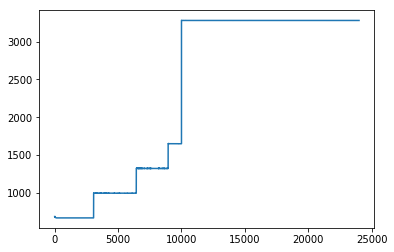

In [238]:
l_minima            = []
map_minima          = []
pos_def             = []
for ii in range(15):
  posterior_corr_loss = []
  print(ii)
  if ii ==1:
    ini = np.zeros((batch_size2*hidden_size)).reshape((batch_size2,hidden_size))+1e-8
  elif ii==0:
    #starting from truth
    ini = sess.run(mu_x,feed_dict={x_ul: np.expand_dims(x_true,-1)})
  else:
    ini = np.random.randn((batch_size2*hidden_size)).reshape((batch_size2,hidden_size))
  sess.run(MAP_reset,feed_dict={x_corr: data, MAP_ini:ini, sigma_corr:sigma_new})
#   for jj in range(3):
#     opt_BFGS.minimize(sess,feed_dict={x_corr: data, sigma_corr:sigma_new, lr: lrate})
#     ll=sess.run(loss_MAP,feed_dict={x_corr: data, sigma_corr:sigma_new, lr: lrate})
#     posterior_corr_loss.append(ll)
  lrate=1e-1
  for jj in range(10000):
    inv_T= np.round(0.5*np.exp(-(1.-jj/10000)),decimals=1)
    _, ll = sess.run([opt_op_MAP,loss_MAP],feed_dict={x_corr: data, sigma_corr:sigma_new, lr: lrate, inverse_T:inv_T})
    posterior_corr_loss.append(ll)
    if jj%1000==0:
      print(ll, inv_T)
  lrate=1e-2
  for jj in range(10000):
    _, ll = sess.run([opt_op_MAP,loss_MAP],feed_dict={x_corr: data, sigma_corr:sigma_new, lr: lrate})
    posterior_corr_loss.append(ll)
    if jj%1000==0:
      print(ll)
  lrate=1e-3
  print('switching to lr', lrate)
  for jj in range(4000):
    _, ll = sess.run([opt_op_MAP,loss_MAP],feed_dict={x_corr: data, sigma_corr:sigma_new, lr: lrate})
    posterior_corr_loss.append(ll)
    if jj%1000==0:
      print(ll)
  ev= sess.run(eig1,feed_dict={x_corr: data, sigma_corr:sigma_new,true_hess:True})
  print(ev)
  if np.all(ev>0.):
    if ii is not 0:
      pos_def+=[ii]

  plt.plot(posterior_corr_loss,label='data_loss')
  plt.show()
  l_minima+=[ll]
  map_minima+=[sess.run([MAP],feed_dict={x_corr: data, sigma_corr:sigma_new})]


In [239]:
print(pos_def)

[4, 5, 6, 7, 9, 11, 12]


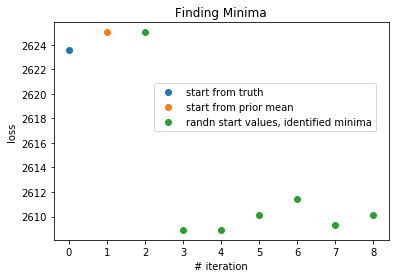

In [240]:
# print(pos_def)
map_minima = np.asarray(map_minima)
l_minima   = np.asarray(l_minima)
l_minima_pos_def   = l_minima[pos_def]
map_minima_pos_def = map_minima[pos_def]
plt.figure()
plt.title('Finding Minima')
plt.plot(0,l_minima[0],ls='',marker='o',label='start from truth')
plt.plot(1,l_minima[1],ls='',marker='o',label='start from prior mean')
plt.plot(np.arange(len(map_minima_pos_def))+2,l_minima_pos_def,ls='',marker='o', label='randn start values, identified minima')
plt.xlabel('# iteration')
plt.ylabel('loss')
plt.legend(loc=(0.3,0.5))
plt.savefig(plot_path+'minimzation_results_xmin%d_xmax%d_annealing.png'%(minx,maxx),bbox_inches='tight')
plt.show()

In [0]:
import pickle
try:
  l_minima,map_minima,l_minima_pos_def,map_minima_pos_def = pickle.load(open(minima_path+'nvp_minima_xmin%d_xmax%d_annealing.pkl'%(minx,maxx),'rb'))
  #l_minima,map_minima = pickle.load(open(minima_path+'nvp_minima_xmin%d_xmax%d.pkl'%(minx,maxx),'rb'))
except:
  pickle.dump([l_minima,map_minima,l_minima_pos_def,map_minima_pos_def],open(minima_path+'nvp_minima_xmin%d_xmax%d_annealing.pkl'%(minx,maxx),'wb'))
  
map_minima = np.asarray(map_minima)
l_minima   = np.asarray(l_minima)

In [152]:
print(map_minima[0])
print(VI_f_mean)
print(VI_mean)

[[[ 2.7205856  -1.2527179  -0.34172425  1.6792735   0.30119264
    0.9797948  -0.3276317  -2.3625302   0.79844385 -0.31930453]]]
[[-0.64900273 -1.0745004  -1.3077915   2.6800232   0.56117857  0.9857219
  -3.762606    0.17987494  2.7829196   2.9288723 ]]
[[ 1.5420538  -0.42289233 -0.91307974  0.8211902   0.13227974  0.9008279
   0.4744373  -3.235739    0.2653391   1.0798557 ]]


**Sample posterior of (un)corrupted data**

In [0]:
samples_mcmc, mcmc_stats_ = sess.run([mcmc_samples,mcmc_stats],feed_dict={x_corr: np.expand_dims(masked_data,-1),sigma_corr:sigma_new, nvp_prior:True})

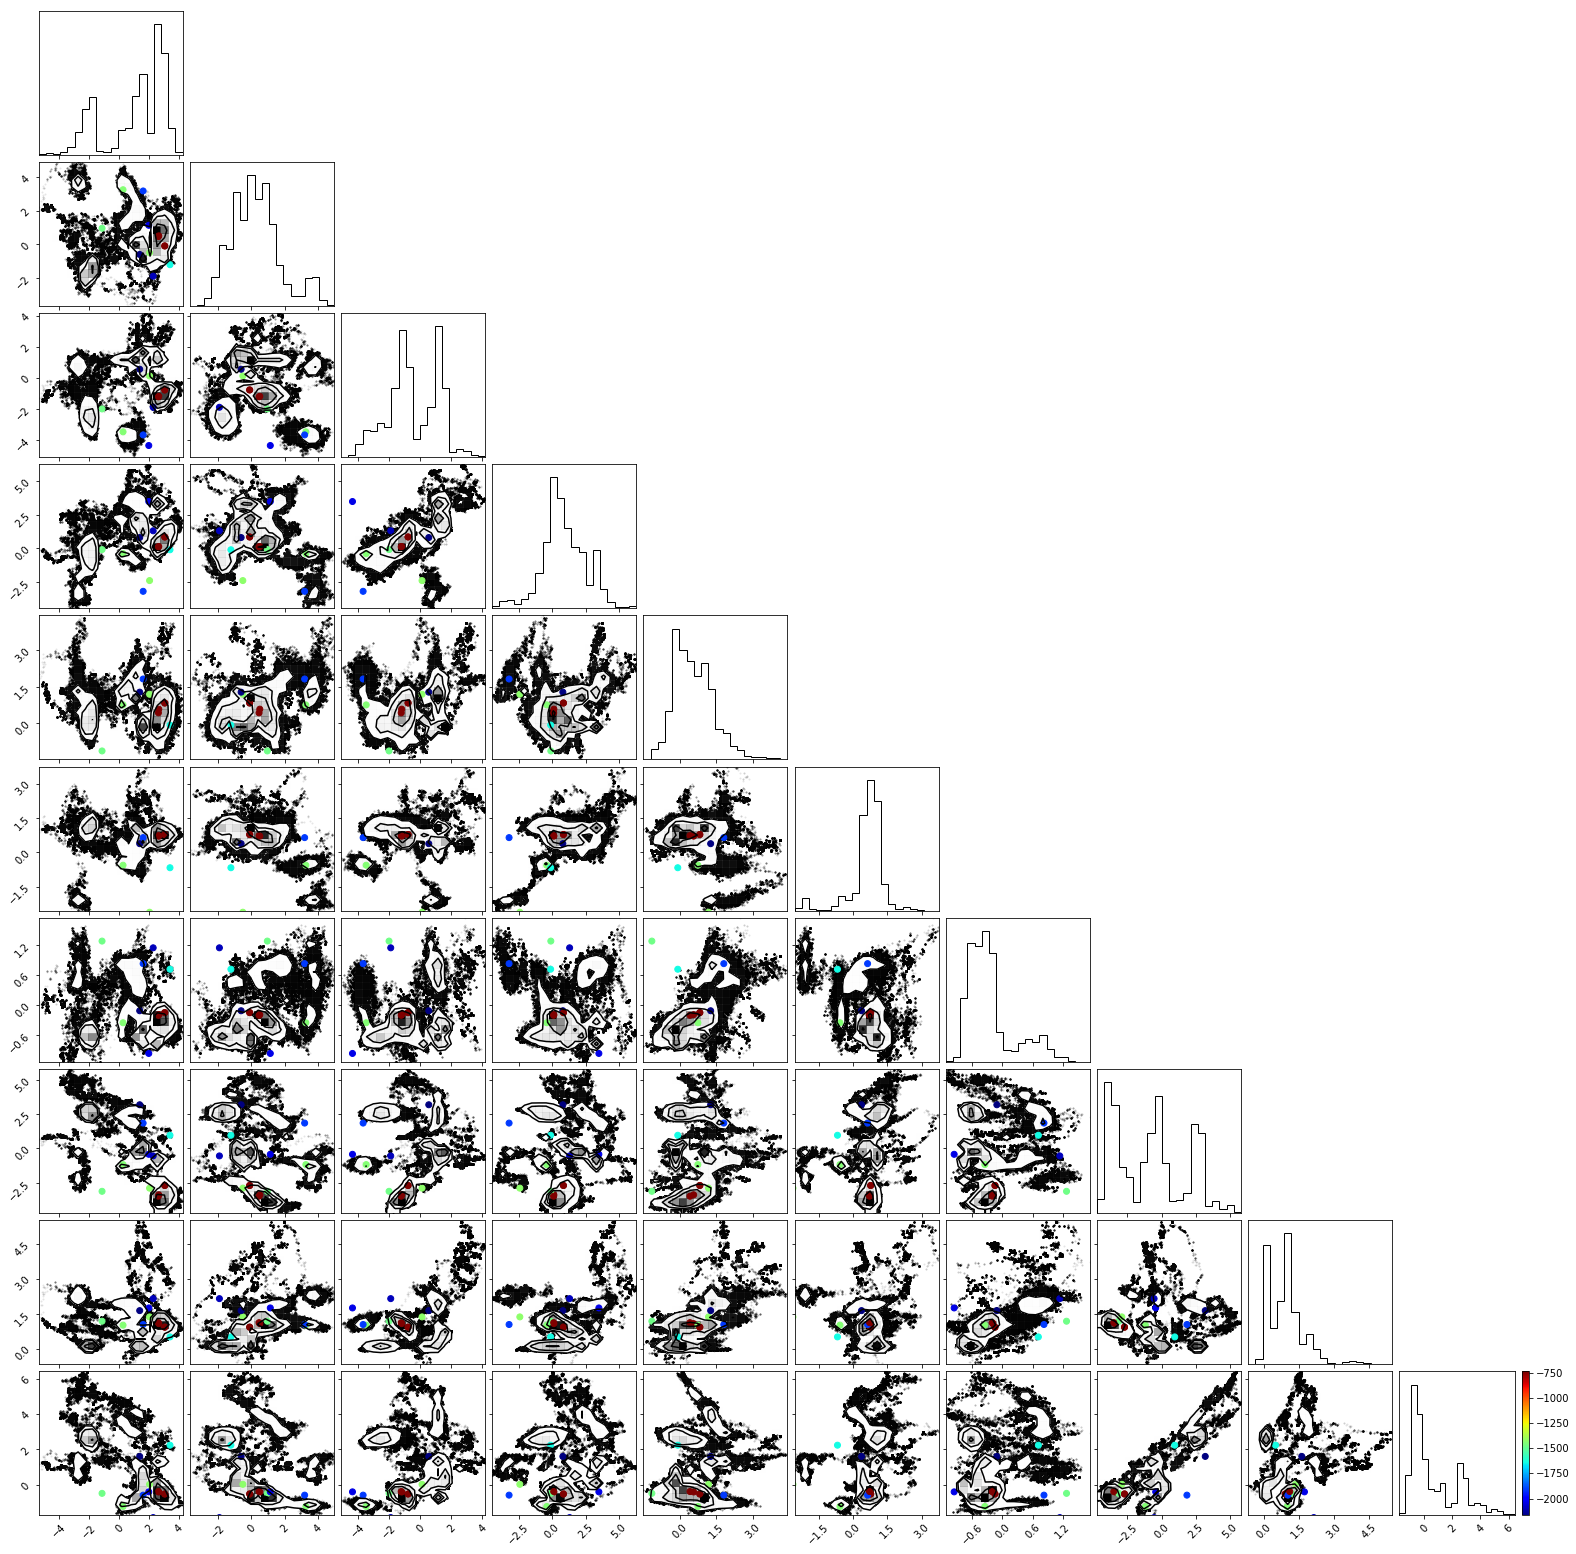

In [123]:
figure = corner.corner(np.reshape(samples_mcmc,[-1,hidden_size]))
axes   = np.array(figure.axes).reshape((hidden_size, hidden_size))

# # # # Loop over the histograms
for yi in range(hidden_size):
    for xi in range(yi):
        ax = axes[yi, xi]
        ax_=ax.scatter(map_minima[:,0,0,xi], map_minima[:,0,0,yi], c=-l_minima, cmap='jet')
        #for i, txt in enumerate(l_minima_old):
        #  ax.annotate('%d'%txt, (map_minima_old[i,0,0,xi], map_minima_old[i,0,0,yi]),color='red', fontsize=10)
plt.colorbar(ax_)

In [0]:
#corrupted data
samples_, kernel_results_ = sess.run([hmc_samples, hmc_kernel_results],feed_dict={x_corr: np.expand_dims(masked_data,-1),sigma_corr:sigma_new, nvp_prior:True})

In [96]:
samples_.shape
print(max(kernel_results_.accepted_results.target_log_prob.flatten()),-min(l_minima))

-987.4353 -734.68427


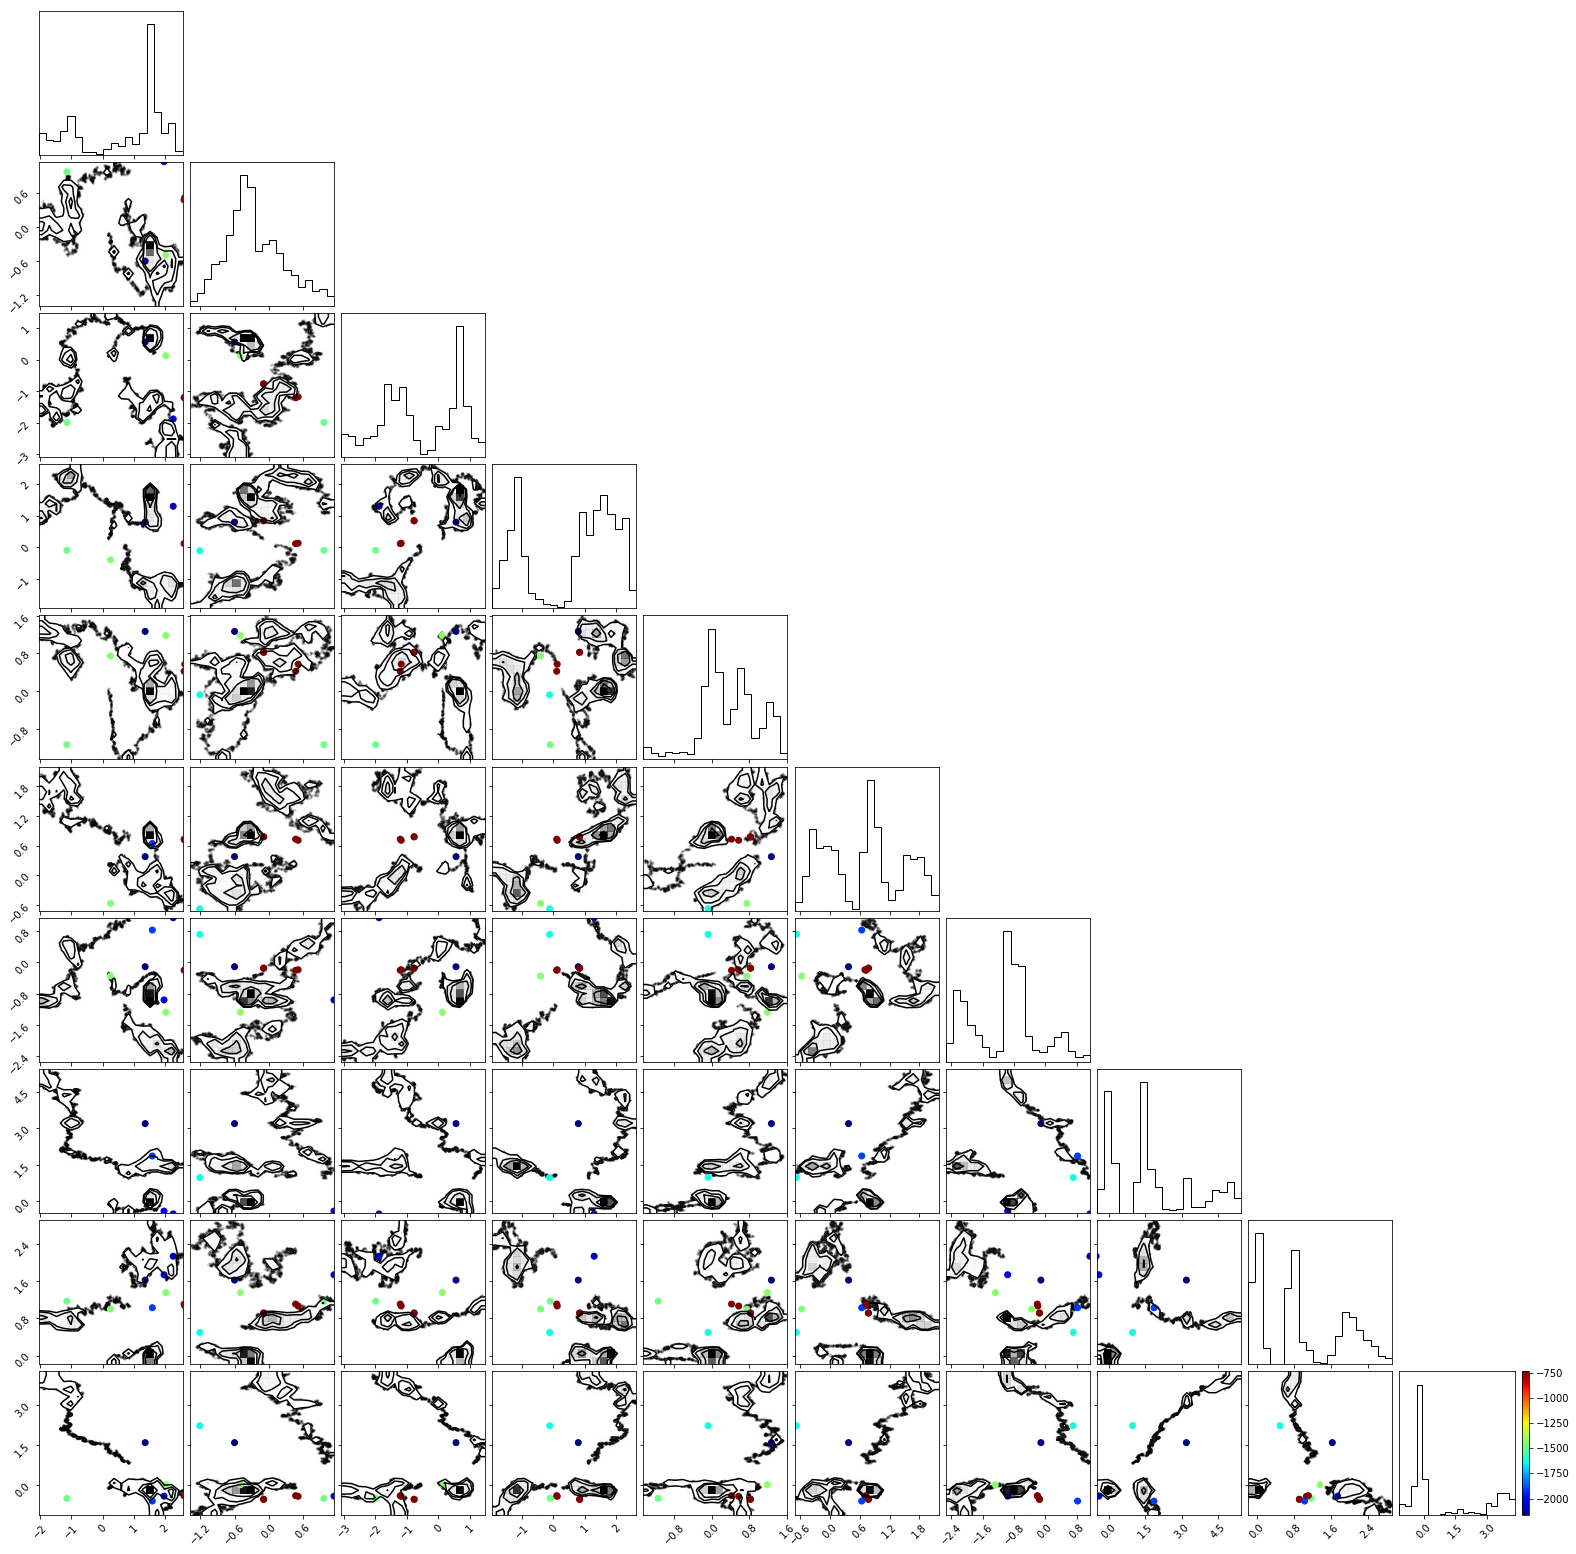

In [111]:
order = np.argsort(l_minima)

figure = corner.corner(np.reshape(samples_,[-1,hidden_size]))#,truths = map_minima_old[order][0,0,0,:])
axes   = np.array(figure.axes).reshape((hidden_size, hidden_size))

# # # # Loop over the histograms
for yi in range(hidden_size):
    for xi in range(yi):
        ax = axes[yi, xi]
        ax_=ax.scatter(map_minima[:,0,0,xi], map_minima[:,0,0,yi], c=-l_minima, cmap='jet')
        #for i, txt in enumerate(l_minima_old):
        #  ax.annotate('%d'%txt, (map_minima_old[i,0,0,xi], map_minima_old[i,0,0,yi]),color='red', fontsize=10)
plt.colorbar(ax_)

mean:0.1693  stddev:0.9419  acceptance:0.6615


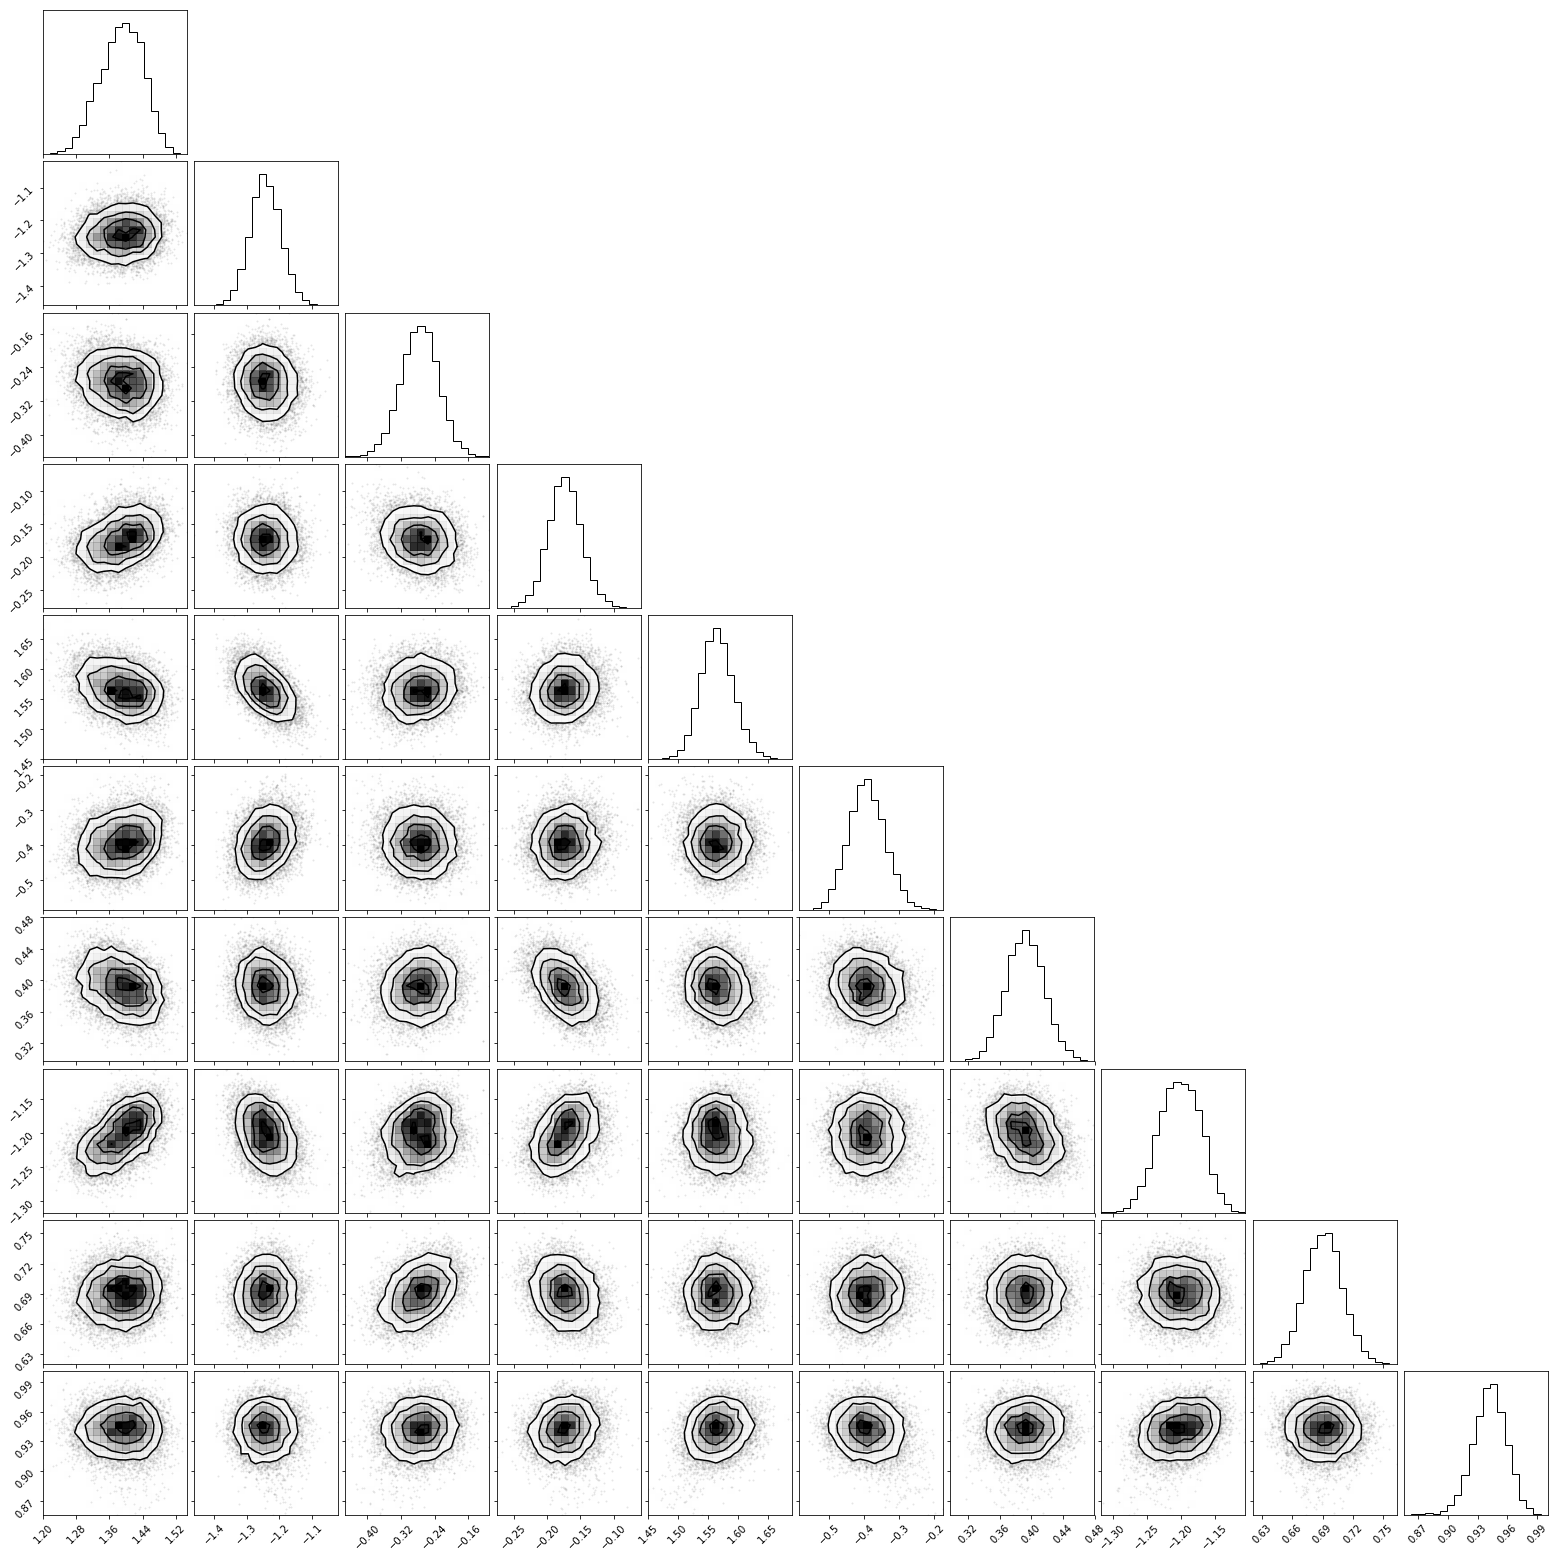

In [16]:
#uncorrupted data
samples_, kernel_results_ = sess.run([samples, kernel_results],feed_dict={x_corr: np.expand_dims(x_true,-1)})
_ = corner.corner(samples_[:,0,:])

In [105]:
data.shape

(1, 784, 1)

**get covariances around minima**

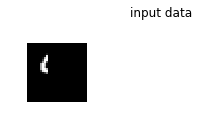

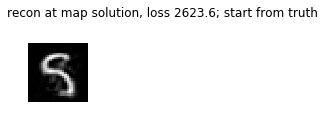

/usr/local/lib/python3.6/dist-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


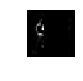

eigenvalues before and after inverse, approx hessian
[array([[9.9184453e-01, 9.9516732e-01, 9.9965870e-01, 9.9988699e-01,
        9.9998695e-01, 1.0000060e+00, 1.0000629e+00, 1.0001281e+00,
        1.0051106e+00, 2.4793750e+05]], dtype=float32), array([[4.03327405e-06, 9.97297077e-01, 9.99281325e-01, 9.99841654e-01,
        9.99982384e-01, 1.00000565e+00, 1.00004550e+00, 1.00015209e+00,
        1.00082063e+00, 1.00255189e+00]])]


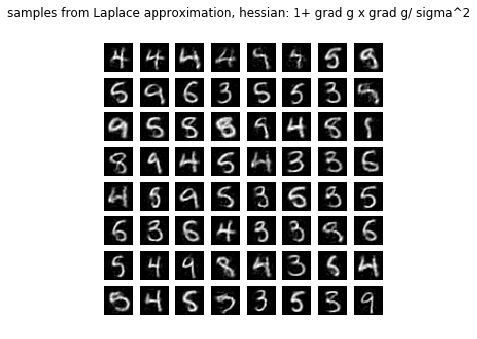

covariances
(1, 10, 10)


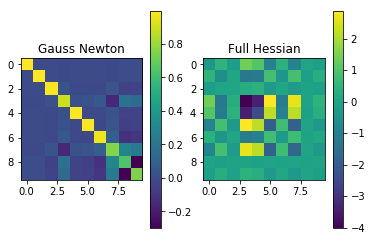

hessians
(1, 10, 10)


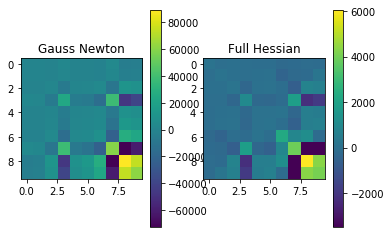

eigenvalues before and after inverse, full hessian
[array([[-3.1289673e+00, -8.5897386e-02,  2.1173615e+00,  8.1186886e+00,
         1.5889627e+01,  5.3757034e+01,  3.2009775e+02,  5.6712170e+02,
         3.4742297e+03,  1.3625928e+04]], dtype=float32), array([[-1.16836649e+01, -3.19545499e-01,  7.33895034e-05,
         2.87833589e-04,  1.76329213e-03,  3.12404204e-03,
         1.86022233e-02,  6.29343938e-02,  1.23171451e-01,
         4.72297831e-01]])]
1
full hessian fails


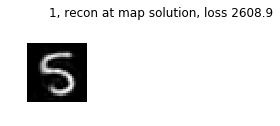

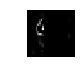

eigenvalues before and after inverse, approx hessian
[array([[9.9910975e-01, 9.9946219e-01, 9.9977452e-01, 9.9998075e-01,
        9.9999881e-01, 1.0000368e+00, 1.0000536e+00, 1.0001280e+00,
        1.0010661e+00, 3.0949539e+04]], dtype=float32), array([[3.23106583e-05, 9.99511928e-01, 9.99917670e-01, 9.99953793e-01,
        9.99960699e-01, 9.99998919e-01, 1.00000138e+00, 1.00007705e+00,
        1.00015763e+00, 1.00026299e+00]])]


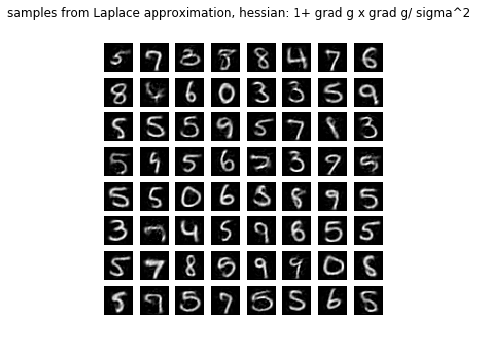

covariances
(1, 10, 10)


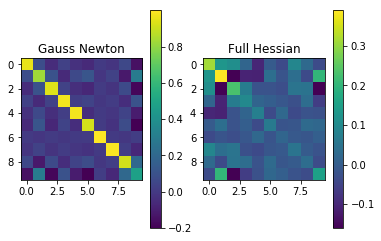

hessians
(1, 10, 10)


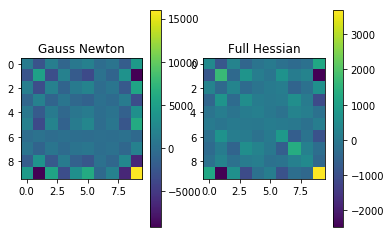

eigenvalues before and after inverse, full hessian
[array([[1.4533565e+00, 2.0101302e+00, 8.2902069e+00, 1.3195562e+01,
        3.1303087e+01, 1.1291185e+02, 1.4359653e+02, 5.5603003e+02,
        2.2069097e+03, 6.5150186e+03]], dtype=float32), array([[1.53491509e-04, 4.53122191e-04, 1.79846402e-03, 6.96397959e-03,
        8.85648149e-03, 3.19454052e-02, 7.57821097e-02, 1.20626636e-01,
        4.97473529e-01, 6.88251808e-01]])]
1


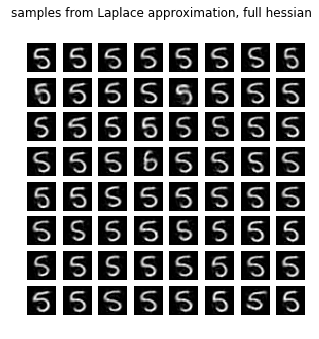

diagonal approx


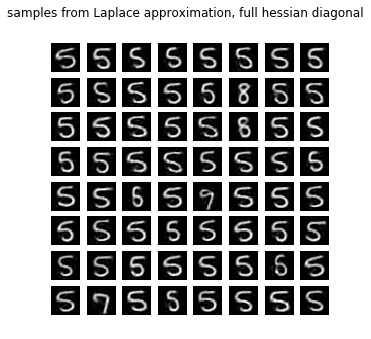

hessian successful 1


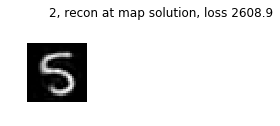

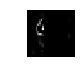

eigenvalues before and after inverse, approx hessian
[array([[9.9959487e-01, 9.9986374e-01, 9.9997532e-01, 9.9997818e-01,
        9.9999994e-01, 1.0000476e+00, 1.0000658e+00, 1.0004812e+00,
        1.0022726e+00, 3.1344941e+04]], dtype=float32), array([[3.19030734e-05, 9.99840777e-01, 9.99870561e-01, 9.99904286e-01,
        9.99991288e-01, 9.99999993e-01, 1.00000470e+00, 1.00002561e+00,
        1.00019772e+00, 1.00028852e+00]])]


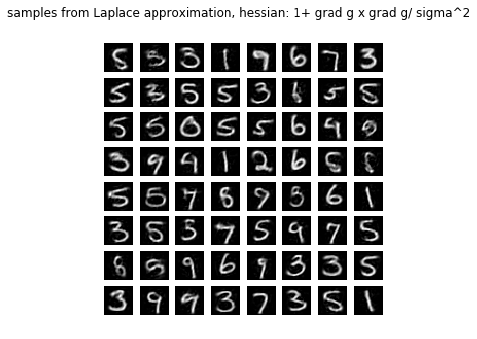

covariances
(1, 10, 10)


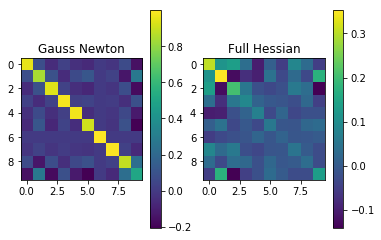

hessians
(1, 10, 10)


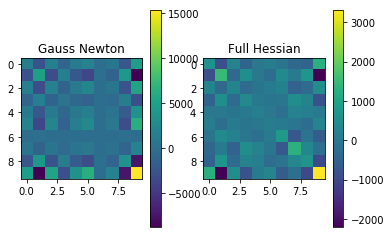

eigenvalues before and after inverse, full hessian
[array([[1.6907172e+00, 1.9699421e+00, 9.6170263e+00, 1.3625298e+01,
        4.0423946e+01, 8.3760330e+01, 1.4931796e+02, 4.6269647e+02,
        2.2495625e+03, 6.1115850e+03]], dtype=float32), array([[1.63623660e-04, 4.44530772e-04, 2.16124460e-03, 6.69711179e-03,
        1.19388093e-02, 2.47375707e-02, 7.33925030e-02, 1.03983311e-01,
        5.07719945e-01, 5.91594416e-01]])]
1


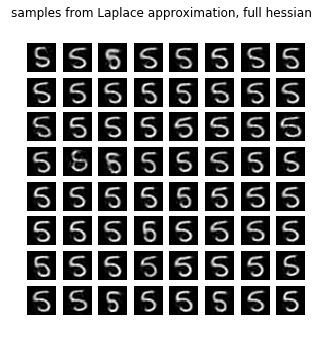

diagonal approx


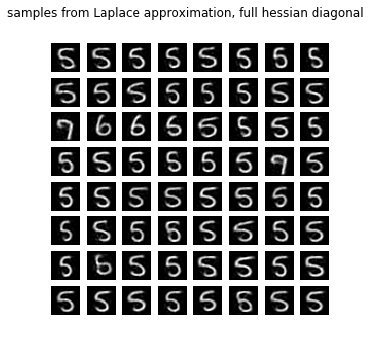

hessian successful 2


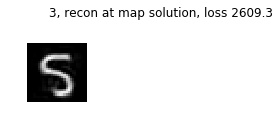

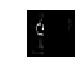

eigenvalues before and after inverse, approx hessian
[array([[9.9853772e-01, 9.9992758e-01, 9.9998951e-01, 9.9999976e-01,
        1.0000007e+00, 1.0000064e+00, 1.0000212e+00, 1.0001850e+00,
        1.0002706e+00, 1.8604414e+04]], dtype=float32), array([[5.37506980e-05, 9.99837960e-01, 9.99942026e-01, 9.99971039e-01,
        9.99998073e-01, 1.00000025e+00, 1.00000370e+00, 1.00001160e+00,
        1.00002269e+00, 1.00019562e+00]])]


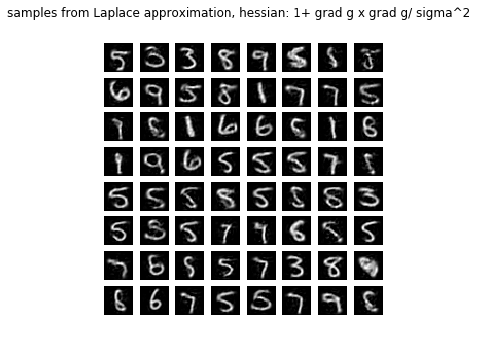

covariances
(1, 10, 10)


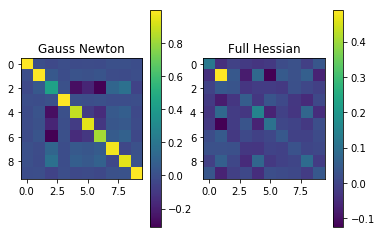

hessians
(1, 10, 10)


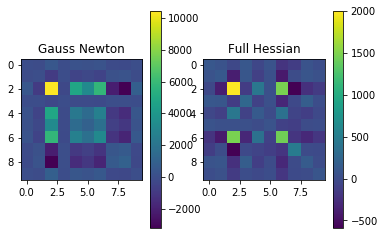

eigenvalues before and after inverse, full hessian
[array([[1.6565976e+00, 4.9564433e+00, 6.3733077e+00, 1.0006663e+01,
        1.3486968e+01, 5.8042603e+01, 1.1520152e+02, 2.6062918e+02,
        8.0160730e+02, 3.6270479e+03]], dtype=float32), array([[2.75706222e-04, 1.24749334e-03, 3.83686591e-03, 8.68044112e-03,
        1.72287431e-02, 7.41450921e-02, 9.99386215e-02, 1.56904849e-01,
        2.01750955e-01, 6.03641177e-01]])]
1


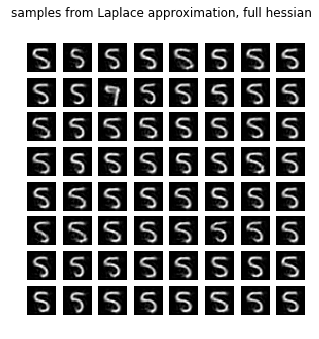

diagonal approx


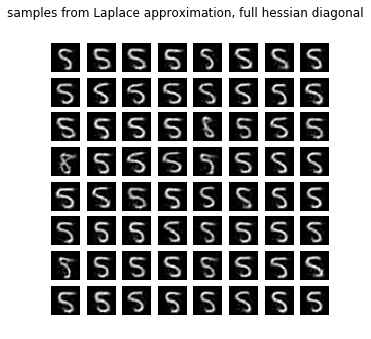

hessian successful 3


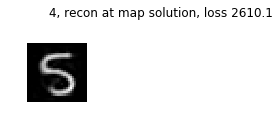

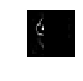

eigenvalues before and after inverse, approx hessian
[array([[9.9792516e-01, 9.9981397e-01, 9.9991322e-01, 9.9997681e-01,
        1.0000137e+00, 1.0000744e+00, 1.0001334e+00, 1.0002830e+00,
        1.0010302e+00, 7.5624516e+04]], dtype=float32), array([[1.32232274e-05, 9.99100933e-01, 9.99853065e-01, 9.99871035e-01,
        9.99956401e-01, 1.00000480e+00, 1.00003722e+00, 1.00009944e+00,
        1.00012687e+00, 1.00018069e+00]])]


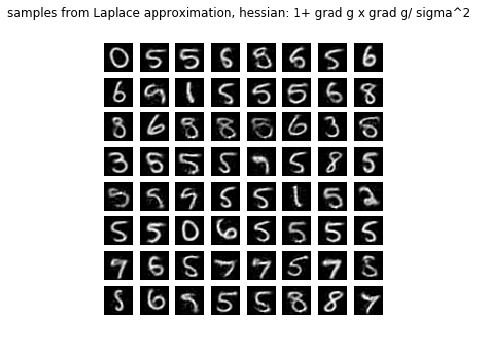

covariances
(1, 10, 10)


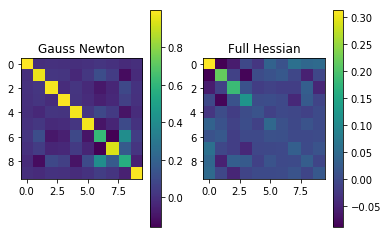

hessians
(1, 10, 10)


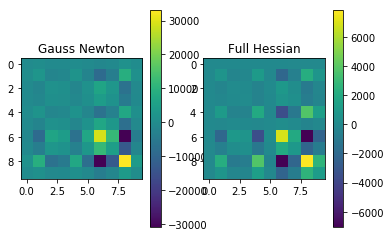

eigenvalues before and after inverse, full hessian
[array([[2.43661690e+00, 3.64968109e+00, 6.20037460e+00, 1.13319111e+01,
        2.79945068e+01, 1.27852715e+02, 1.66651657e+02, 3.09739716e+02,
        5.90232910e+02, 1.85862852e+04]], dtype=float32), array([[5.38031066e-05, 1.69424655e-03, 3.22851167e-03, 6.00055300e-03,
        7.82148761e-03, 3.57215342e-02, 8.82455389e-02, 1.61281144e-01,
        2.73993700e-01, 4.10396048e-01]])]
1


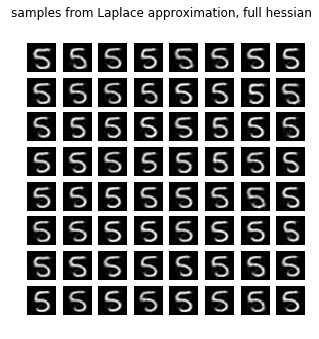

diagonal approx


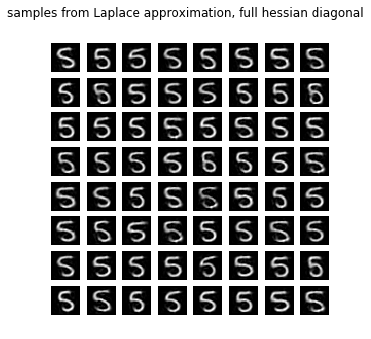

hessian successful 4


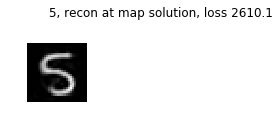

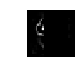

eigenvalues before and after inverse, approx hessian
[array([[9.9610144e-01, 9.9972755e-01, 9.9992156e-01, 9.9998856e-01,
        1.0000004e+00, 1.0000210e+00, 1.0000845e+00, 1.0000975e+00,
        1.0003633e+00, 5.0727414e+04]], dtype=float32), array([[1.97132112e-05, 9.99198047e-01, 9.99929793e-01, 9.99977813e-01,
        9.99979466e-01, 1.00000002e+00, 1.00001225e+00, 1.00006298e+00,
        1.00015270e+00, 1.00041733e+00]])]


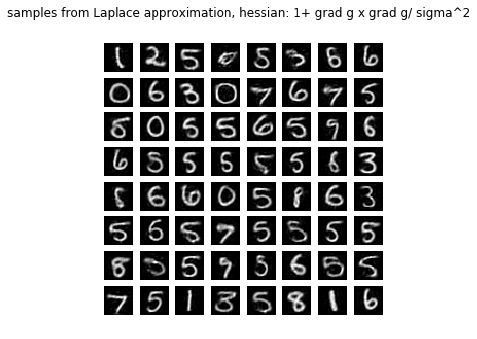

covariances
(1, 10, 10)


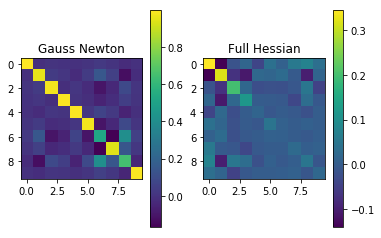

hessians
(1, 10, 10)


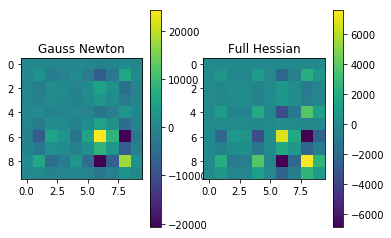

eigenvalues before and after inverse, full hessian
[array([[1.8378361e+00, 3.2471449e+00, 6.1703358e+00, 1.2698883e+01,
        2.5894390e+01, 1.3349368e+02, 1.3845110e+02, 3.1578091e+02,
        5.8486060e+02, 1.8224449e+04]], dtype=float32), array([[5.48713214e-05, 1.70980970e-03, 3.16675969e-03, 7.22275507e-03,
        7.49096411e-03, 3.86182192e-02, 7.87458154e-02, 1.62065126e-01,
        3.07965503e-01, 5.44088325e-01]])]
1


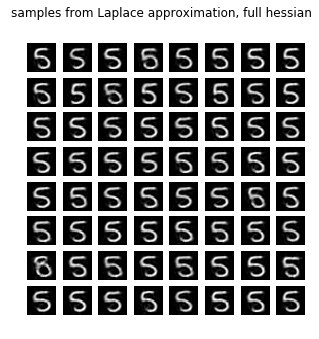

diagonal approx


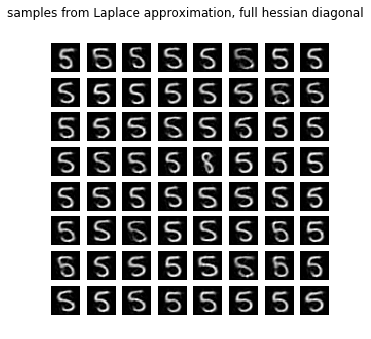

hessian successful 5


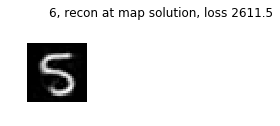

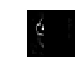

eigenvalues before and after inverse, approx hessian
[array([[9.9797064e-01, 9.9983048e-01, 9.9993604e-01, 9.9998987e-01,
        1.0000027e+00, 1.0000154e+00, 1.0000715e+00, 1.0002434e+00,
        1.0007401e+00, 3.5806516e+04]], dtype=float32), array([[2.79278766e-05, 9.99739552e-01, 9.99877644e-01, 9.99967527e-01,
        9.99984006e-01, 1.00000170e+00, 1.00000825e+00, 1.00003465e+00,
        1.00011448e+00, 1.00018857e+00]])]


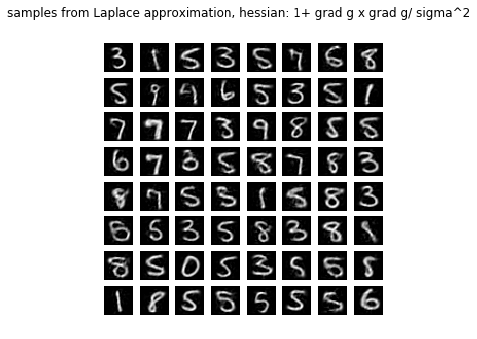

covariances
(1, 10, 10)


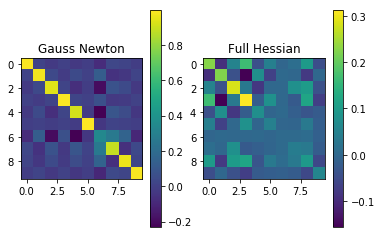

hessians
(1, 10, 10)


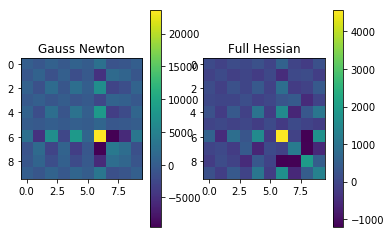

eigenvalues before and after inverse, full hessian
[array([[1.46025372e+00, 3.06758571e+00, 5.85684490e+00, 9.37437439e+00,
        1.92986736e+01, 4.25497017e+01, 1.04846436e+02, 4.50826965e+02,
        3.58082251e+03, 6.46823438e+03]], dtype=float32), array([[1.54601681e-04, 2.79265502e-04, 2.21814404e-03, 9.53770092e-03,
        2.35018393e-02, 5.18173044e-02, 1.06671992e-01, 1.70733228e-01,
        3.25996760e-01, 6.84777231e-01]])]
1


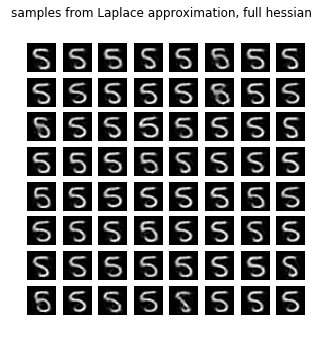

diagonal approx


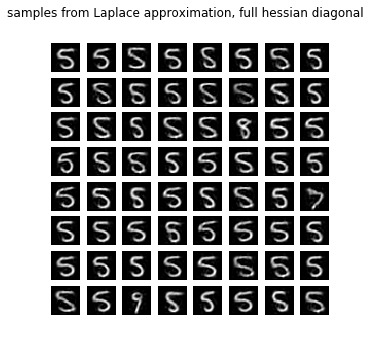

hessian successful 6


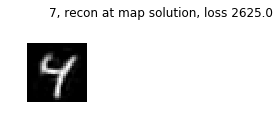

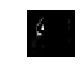

eigenvalues before and after inverse, approx hessian
[array([[9.9397993e-01, 9.9845791e-01, 9.9961388e-01, 9.9999434e-01,
        1.0000265e+00, 1.0001647e+00, 1.0001708e+00, 1.0011905e+00,
        1.0107316e+00, 1.7444530e+05]], dtype=float32), array([[5.73245757e-06, 9.97211471e-01, 9.99530519e-01, 9.99919215e-01,
        9.99948785e-01, 9.99977933e-01, 1.00002942e+00, 1.00006519e+00,
        1.00118036e+00, 1.00244012e+00]])]


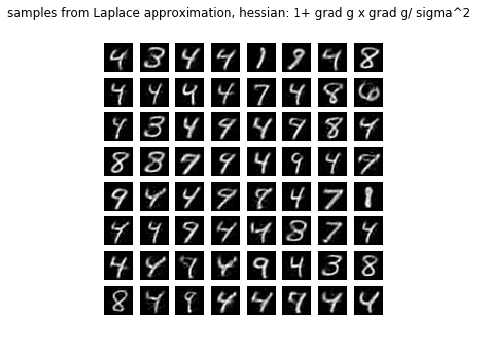

covariances
(1, 10, 10)


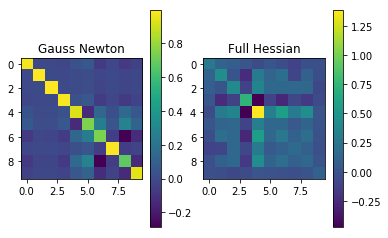

hessians
(1, 10, 10)


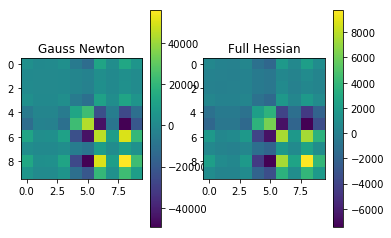

eigenvalues before and after inverse, full hessian
[array([[4.2691800e-01, 1.5703635e+00, 2.1143451e+00, 2.8601789e+00,
        6.6159997e+00, 1.1695608e+01, 1.0197038e+02, 1.3406503e+02,
        1.3699541e+03, 2.7916980e+04]], dtype=float32), array([[3.58204959e-05, 7.29951281e-04, 7.45906720e-03, 9.80681838e-03,
        8.55067399e-02, 1.51148551e-01, 3.49651502e-01, 4.73014222e-01,
        6.36748365e-01, 2.34906912e+00]])]
1


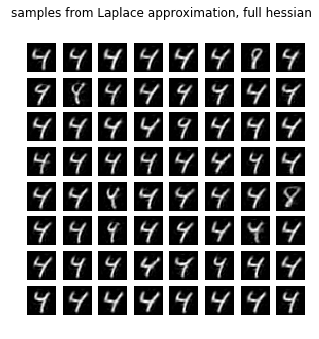

diagonal approx


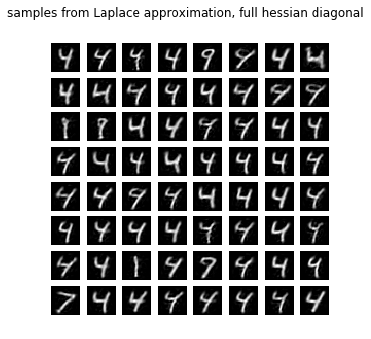

hessian successful 7


In [241]:
figure(figsize=(5,5))
suptitle('input data')
for i in range(min(batch_size2,16)):
    subplot(4,4,i+1)
    imshow(np.reshape(data[i,:],(28,28)),cmap='gray',vmin=0)
    axis('off')
plt.show()

varis = [] 

order      = np.argsort(l_minima_pos_def)
results    = np.concatenate((np.expand_dims(map_minima[0],0),map_minima_pos_def[order]), axis=0)
l_results  = np.concatenate((np.expand_dims(l_minima[0],0),l_minima_pos_def[order]), axis=0)
# go through minima
for ii,ini_ in enumerate(results):
  
  
  _ = sess.run(MAP_reset,feed_dict={x_corr: data, MAP_ini:ini_[0], sigma_corr:sigma_new})
  mean_at_map = sess.run(likeli_MAP.mean(),feed_dict={x_corr: data, sigma_corr:sigma_new})
  
  # Laplace approximation with approximate Hessian
  _ = sess.run(update2,feed_dict={x_corr: data, sigma_corr:sigma_new, MAP_ini:ini_[0]})
  _ = sess.run(update3,feed_dict={x_corr: data, sigma_corr:sigma_new, MAP_ini:ini_[0], true_hess:False})
  

  figure(figsize=(5,5))
  if ii==0:
    suptitle('recon at map solution, loss %.1f; start from truth'%l_results[ii])
  else:
    suptitle('%d, recon at map solution, loss %.1f'%(ii,l_results[ii]))
  for i in range(min(batch_size2,16)):
      subplot(4,4,i+1)
      imshow(np.reshape(mean_at_map[i,:,0],(28,28)),cmap='gray',vmin=0)
      axis('off')
      plt.show()
      subplot(4,4,i+1)
      imshow(np.reshape(mean_at_map[i,:,0]*mask,(28,28)),cmap='gray',vmin=0)
      axis('off')
      
      subplot(4,4,i+1)
      imshow(np.reshape((mean_at_map[i,:,0]-data[0,:,0])*mask,(28,28)),cmap='gray',vmin=0)
      axis('off')
  plt.show()

  # get diagonal
  varis+=[sess.run(tf.linalg.diag_part(approx_posterior_laplace.covariance()),feed_dict={x_corr: data, sigma_corr:sigma_new, true_hess:True})]
  
  print('eigenvalues before and after inverse, approx hessian')
  print(sess.run([eig1, eig2],feed_dict={x_corr: data, sigma_corr:sigma_new, true_hess:False}))

  # get samples 
  l_samples = sess.run(lap_mean,feed_dict={x_corr: data, sigma_corr:sigma_new, true_hess:False})
  figure(figsize=(5,5))
  suptitle('samples from Laplace approximation, hessian: 1+ grad g x grad g/ sigma^2')
  for i in range(sample_size_z):
      subplot(8,8,i+1)
      imshow(np.reshape(l_samples[i,:,0],(28,28)),cmap='gray',vmin=0)
      axis('off')
  plt.show()
  
  
  ## plot sigma
  print('covariances')
  sigma_m = sess.run(sigma_hess,feed_dict={x_corr: data, sigma_corr:sigma_new, true_hess:False})
  sigma_m_t = sess.run(sigma_hess,feed_dict={x_corr: data, sigma_corr:sigma_new, true_hess:True})
  print(sigma_m.shape)
  plt.figure()
  subplot(1,2,1)
  title('Gauss Newton')
  plt.imshow(sigma_m[0,:,:])
  plt.colorbar()
  subplot(1,2,2)
  title('Full Hessian')
  plt.imshow(sigma_m_t[0,:,:])
  plt.colorbar()
  plt.show()
  
  print('hessians')
  sigma_m = sess.run(hess_approx,feed_dict={x_corr: data, sigma_corr:sigma_new, true_hess:False})
  sigma_m_t = sess.run(hess2,feed_dict={x_corr: data, sigma_corr:sigma_new, true_hess:True})
  print(sigma_m.shape)
  plt.figure()
  subplot(1,2,1)
  title('Gauss Newton')
  plt.imshow(sigma_m[0,:,:])
  plt.colorbar()
  subplot(1,2,2)
  title('Full Hessian')
  plt.imshow(sigma_m_t[0,:,:])
  plt.colorbar()
  plt.show()
  
  
  #same for full hessian
  print('eigenvalues before and after inverse, full hessian')
  print(sess.run([eig1, eig2],feed_dict={x_corr: data, sigma_corr:sigma_new, true_hess:True}))
  try:
    for s in [1]:
      print(s)
   
      _ = sess.run(update3,feed_dict={x_corr: data, sigma_corr:sigma_new, true_hess:True, scale:s})
      l_samples = sess.run(lap_mean,feed_dict={x_corr: data, sigma_corr:sigma_new, true_hess:True, scale:s})
      figure(figsize=(5,5))
      suptitle('samples from Laplace approximation, full hessian')
      for i in range(sample_size_z):
          subplot(8,8,i+1)
          imshow(np.reshape(l_samples[i,:,0],(28,28)),cmap='gray',vmin=0)
          axis('off')
      plt.show()
      
    print('diagonal approx')
    _ = sess.run(update3,feed_dict={x_corr: data, sigma_corr:sigma_new, true_hess:True, scale:1, diag_hess:True})

    l_samples = sess.run(lap_mean,feed_dict={x_corr: data, sigma_corr:sigma_new, true_hess:True, diag_hess:True})
    figure(figsize=(5,5))
    suptitle('samples from Laplace approximation, full hessian diagonal')
    for i in range(sample_size_z):
        subplot(8,8,i+1)
        imshow(np.reshape(l_samples[i,:,0],(28,28)),cmap='gray',vmin=0)
        axis('off')
    plt.show()
    print('hessian successful',ii)
  except:
    try:
      print('full hessian fails')
    except:
      print('eigen decomp fails')


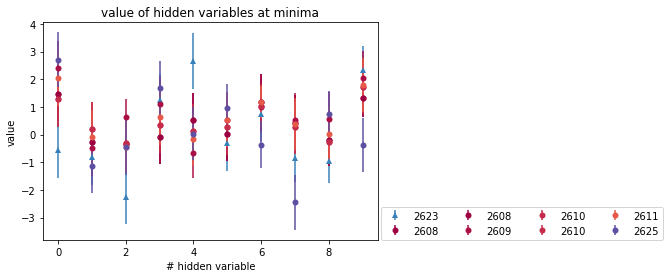

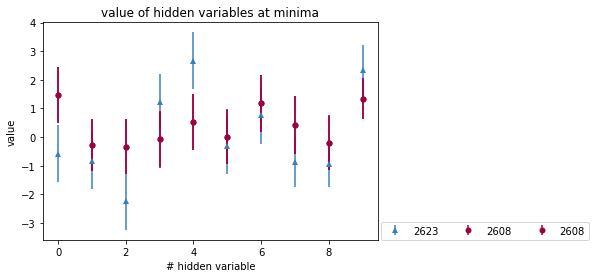

In [245]:
# check if minima are distinct
order = np.argsort(l_minima_pos_def)
map_minima_pos_def = np.asarray(map_minima_pos_def[order])
l_minima_pos_def   = np.asarray(l_minima_pos_def[order])
varis      = np.asarray(varis)

colors = matplotlib.colors.Normalize(vmin=min(l_results), vmax=max(l_results))
cmap = matplotlib.cm.get_cmap('Spectral')

plt.title('value of hidden variables at minima')
for ii in range(len(results)):
  yerr_= np.sqrt(varis[ii,0])
  if ii ==0:
    plt.errorbar(np.arange(hidden_size),np.squeeze(results[ii]), marker='^',ls='', c=cmap(colors(l_results[ii])), mew=0, yerr=yerr_, label ='%d'%l_results[ii])
  else:
    plt.errorbar(np.arange(hidden_size),np.squeeze(results[ii]), marker='o',ls='', c=cmap(colors(l_results[ii])), mew=0, yerr=yerr_, label ='%d'%l_results[ii])
plt.legend(ncol=4, loc=(1.01,0))
plt.xlabel('# hidden variable')
plt.ylabel('value')
plt.savefig(plot_path+'minima_xmin%d_xmax%d_nolbfgs.png'%(minx,maxx),bbox_inches='tight')
plt.show()


plt.title('value of hidden variables at minima')
for ii in range(len(results[0:3])):
  yerr_= np.sqrt(varis[ii,0])
  if ii ==0:
    plt.errorbar(np.arange(hidden_size),np.squeeze(results[ii]), marker='^',ls='', c=cmap(colors(l_results[ii])), mew=0, yerr=yerr_, label ='%d'%l_results[ii])
  else:
    plt.errorbar(np.arange(hidden_size),np.squeeze(results[ii]), marker='o',ls='', c=cmap(colors(l_results[ii])), mew=0, yerr=yerr_, label ='%d'%l_results[ii])
plt.legend(ncol=4, loc=(1.01,0))
plt.xlabel('# hidden variable')
plt.ylabel('value')
plt.savefig(plot_path+'minima_xmin%d_xmax%d_only_two.png'%(minx,maxx),bbox_inches='tight')
plt.show()

**explore posterior around minima**

[[[ 1.4678843  -0.2676418  -0.33345094 -0.07111914  0.52601755
    0.00548367  1.1841637   0.4237173  -0.19210725  1.3414295 ]]]


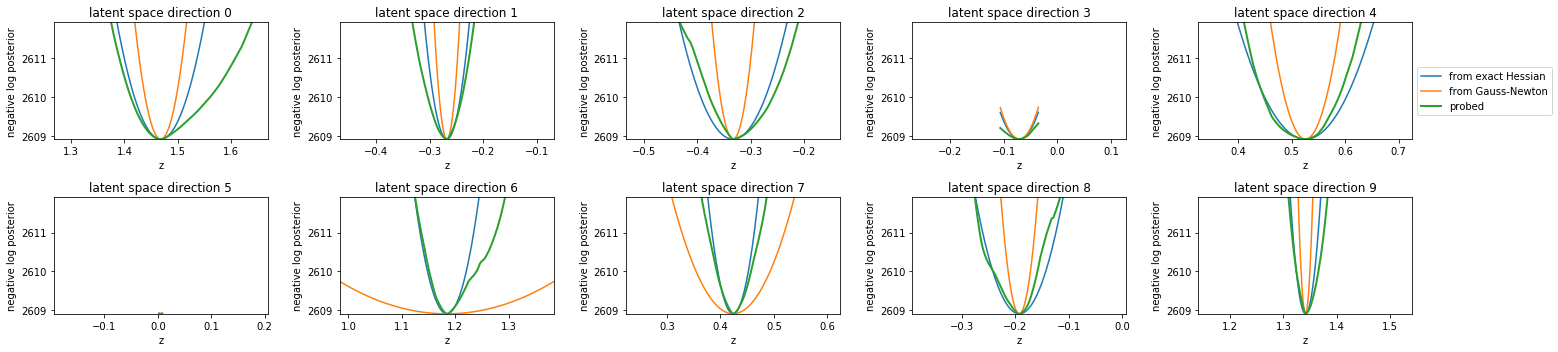

[[[ 2.710552   -1.1175996  -0.4561647   1.6729083   0.03154174
    0.96318597 -0.36048216 -2.4494846   0.74325025 -0.38128066]]]


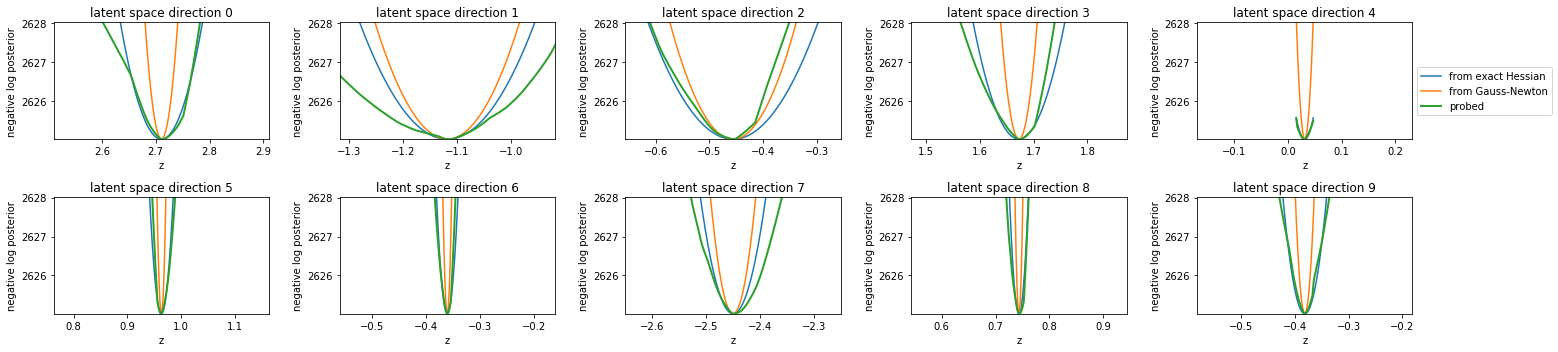

In [253]:
order     = np.append(np.argsort(l_minima_pos_def)[0],np.argsort(l_minima_pos_def)[-1])

# testing Hessian
for ii,ini_ in enumerate(map_minima_pos_def[order]):
  print(ini_)
  # go through minima
  _ = sess.run(MAP_reset,feed_dict={x_corr: data, MAP_ini:ini_[0], sigma_corr:sigma_new})
  # Laplace approximation with approximate Hessian
  _ = sess.run(update2,feed_dict={x_corr: data, sigma_corr:sigma_new, MAP_ini:ini_[0]})
  _ = sess.run(update3,feed_dict={x_corr: data, sigma_corr:sigma_new, MAP_ini:ini_[0], true_hess:True})
  measured_hessian = sess.run(hess2,feed_dict={x_corr: data, sigma_corr:sigma_new, true_hess:True})
  GN_hessian = sess.run(hess_approx,feed_dict={x_corr: data, sigma_corr:sigma_new, true_hess:False})
  ll0 = sess.run(posterior_MAP,feed_dict={x_corr: data, MAP_ini:ini_[0], sigma_corr:sigma_new})
  plt.figure(figsize=(20,5))
  
  for nn in np.arange(hidden_size):
    B    = measured_hessian[0,nn,nn]
    GN   = GN_hessian[0,nn,nn]
    VIm  = np.linalg.inv(VI_cov)[0,nn,nn]

    z_VI  = (0.001*(np.arange(1001)-501))*VI_mean[0,nn]
    
    VImf  = np.linalg.inv(VI_f_cov)[0,nn,nn]

    z_VIf = (0.001*(np.arange(1001)-501))*VI_f_mean[0,nn]

    losses=[]
    
    
    subplot(2,5,nn+1)
    #suptitle('negative log posterior')
    title('latent space direction %d'%nn)
    for jj in np.arange(1001):
      delta_z = np.zeros_like(ini_[0])
      delta_z[:,nn] = (0.001*(jj-501))*ini_[0][:,nn]
      new_ini = ini_[0]+delta_z
      _ = sess.run(MAP_reset,feed_dict={x_corr: data, MAP_ini:new_ini, sigma_corr:sigma_new})
      ll = sess.run(posterior_MAP,feed_dict={x_corr: data, MAP_ini:new_ini, sigma_corr:sigma_new})
      losses.append(-ll)
      

    
    
    plt.plot(ini_[0][:,nn]+(0.001*(np.arange(1001)-501))*ini_[0][:,nn],-ll0+B*((0.001*(np.arange(1001)-501))*ini_[0][:,nn])**2,label='from exact Hessian')
    #plt.plot(z_VI+VI_mean[0,nn],-ll0+VIm*z_VI**2,label='from mean field VI', color='tomato')
    #plt.plot(z_VIf+VI_f_mean[0,nn],-ll0+VImf*z_VIf**2,label='from full rank VI', color='darkblue')
    plt.plot(ini_[0][:,nn]+(0.001*(np.arange(1001)-501))*ini_[0][:,nn],-ll0+GN*((0.001*(np.arange(1001)-501))*ini_[0][:,nn])**2,label='from Gauss-Newton')
    plt.plot(ini_[0][:,nn]+(0.001*(np.arange(1001)-501))*ini_[0][:,nn],losses,label='probed', lw=2)
    
    
    plt.xlabel('z')
    plt.ylabel('negative log posterior')
    plt.ylim(-ll0,-ll0+3)
#     if nn in [0,1]:
    plt.xlim(ini_[0][:,nn]-0.2, ini_[0][:,nn]+0.2)
#     elif nn in [2,3,4,5,6,9]:
#       plt.xlim(ini_[0][:,nn]-0.1, ini_[0][:,nn]+0.1)
#     elif nn in [7,8]:
#       plt.xlim(ini_[0][:,nn]-0.05, ini_[0][:,nn]+0.05)
  plt.tight_layout()
  plt.legend(loc=(1.02,1.7))
  
  
  
  plt.savefig(plot_path+'probing_posterior_xmin%d_xmax%d_noVI_start0_rescaled_annealing_loss%d.png'%(minx,maxx,-ll0),bbox_inches='tight')
  plt.show()


**Build Gaussian Mixture Model**

In [256]:
mu_     =[]
sigma_  =[]
w_tilde =[]
#diag    =[]

offset  =2200 #for numerical stability
order   = np.append(np.argsort(l_minima_pos_def)[0],np.argsort(l_minima_pos_def)[-1])#np.argsort(l_minima_pos_def)
mus     = map_minima_pos_def[order]

# loop over components, start with lowest, go higher and higher
for ii in range(num_comp):
  
  # do Laplace approximation around this minimum
  sess.run(MAP_reset,feed_dict={x_corr: data, sigma_corr:sigma_new, MAP_ini:mus[ii][0]})
  mu_+=[sess.run(update2,feed_dict={x_corr: data, sigma_corr:sigma_new, MAP_ini:mus[ii][0]})]
  sigma_+=[sess.run(update3,feed_dict={x_corr: data, sigma_corr:sigma_new,MAP_ini:mus[ii][0],true_hess:True})]
  

  logdet_ = sess.run(log_det,feed_dict={x_corr: data, sigma_corr:sigma_new,true_hess:True})
  logprob = sess.run(posterior_MAP,feed_dict={x_corr: data, sigma_corr:sigma_new})
  print(logdet_,logprob,0.5*logdet_+logprob)
  w_tilde+=[np.exp(0.5*logdet_+logprob+offset)]

mu_    = np.reshape(np.asarray(mu_),[1,num_comp,hidden_size])
sigma_ = np.reshape(np.asarray(sigma_),[1,num_comp,hidden_size,hidden_size])

w_tilde= np.asarray(w_tilde)
print(w_tilde)

A = 1./np.sum(w_tilde)

w = w_tilde*A
w = np.squeeze(w)
print(w)


_=sess.run(update_a,feed_dict={x_corr: data, sigma_corr:sigma_new,mu_est: mu_, sigma_est: sigma_, w_est:w })
_=sess.run(update_b,feed_dict={x_corr: data, sigma_corr:sigma_new,mu_est: mu_, sigma_est: sigma_, w_est:w })
_=sess.run(update_c,feed_dict={x_corr: data, sigma_corr:sigma_new,mu_est: mu_, sigma_est: sigma_, w_est:w })
_=sess.run(update_d,feed_dict={x_corr: data, sigma_corr:sigma_new,mu_est: mu_, sigma_est: sigma_, w_est:w })



[-41.70613479] [-2608.9128] [-2629.76590919]
[-32.72798736] [-2625.0151] [-2641.3791304]
[[2.26483792e-187]
 [2.04870412e-192]]
[9.99990954e-01 9.04561679e-06]


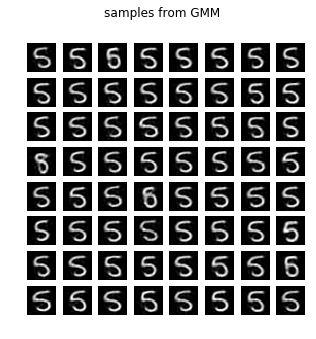

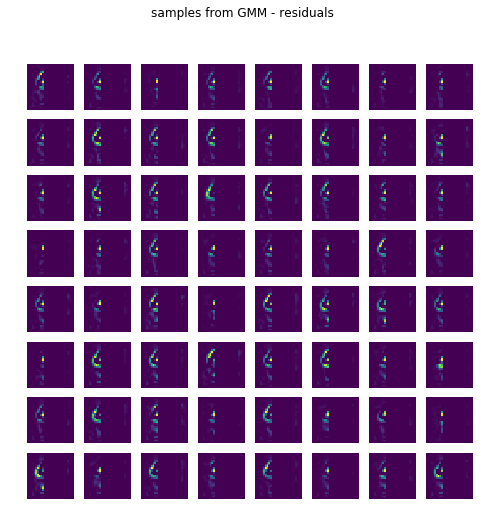

In [257]:
gmm_samples=sess.run(gmm_sample_x,feed_dict={x_corr: data, sigma_corr:sigma_new})

figure(figsize=(5,5))
suptitle('samples from GMM')
for i in range(sample_size_z):
    subplot(8,8,i+1)
    imshow(np.reshape(gmm_samples[i,:,0],(28,28)),cmap='gray',vmin=0)
    axis('off')
plt.savefig(plot_path+'gmm_samples_xmin%d_xmax%d.png'%(minx,maxx),bbox_inches='tight')
plt.show()
figure(figsize=(8,8))
suptitle('samples from GMM - residuals')
for i in range(sample_size_z):
    subplot(8,8,i+1)
    imshow(np.reshape((gmm_samples[i,:,0]-data[0,:,0])*mask,(28,28)),vmin=0)
    axis('off')
plt.savefig(plot_path+'gmm_samples_xmin%d_xmax%d.png'%(minx,maxx),bbox_inches='tight')
plt.show()

In [269]:
losses=[]
for ii in range(100):
  _, ll, mm, ww = sess.run([opt_op_el2o,el2o, mu_gmm,w_gmm],feed_dict={x_corr: data, sigma_corr:sigma_new, lr:1e-5})
  losses.append(ll)
  print(ll,ww)

13559985.0 [0.9756597  0.02888282]
15222756.0 [0.975659   0.02888343]
76600870.0 [0.9756583  0.02888405]
8967153.0 [0.9756576  0.02888466]
34600440.0 [0.97565687 0.02888528]
19077094.0 [0.97565615 0.02888589]
43089508.0 [0.97565544 0.02888651]
17878664.0 [0.9756547  0.02888712]
17436794.0 [0.975654   0.02888774]
13567228.0 [0.9756533  0.02888836]
16548347.0 [0.9756526  0.02888898]
8246890.0 [0.97565186 0.02888961]
8531780.0 [0.97565114 0.02889023]
13458640.0 [0.9756504  0.02889085]
13653618.0 [0.9756497  0.02889147]
9946918.0 [0.975649   0.02889209]
443151700.0 [0.9756483  0.02889272]
35016790.0 [0.9756475  0.02889334]
42688944.0 [0.97564673 0.02889397]
39733680.0 [0.97564596 0.02889461]
10845528.0 [0.9756452  0.02889524]
13783070.0 [0.9756444  0.02889587]
18323586.0 [0.97564363 0.0288965 ]
2335809500.0 [0.97564286 0.02889713]
220923410.0 [0.9756421  0.02889778]
11874776.0 [0.97564393 0.02889623]
12517835.0 [0.9756455 0.0288949]
10079470.0 [0.97564685 0.02889376]
10122223.0 [0.975648  

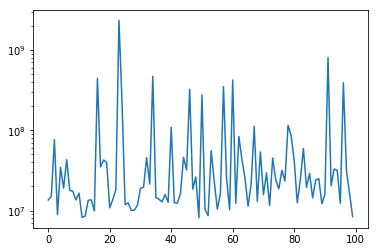

In [270]:
plt.plot(losses)
plt.yscale('log')

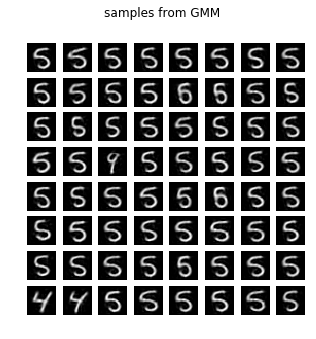

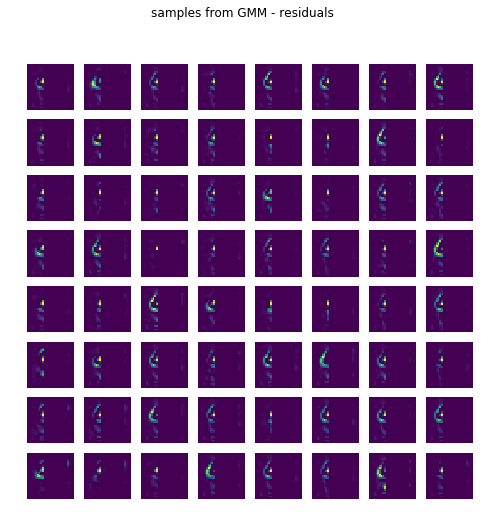

In [271]:
gmm_samples=sess.run(gmm_sample_x,feed_dict={x_corr: data, sigma_corr:sigma_new})

figure(figsize=(5,5))
suptitle('samples from GMM')
for i in range(sample_size_z):
    subplot(8,8,i+1)
    imshow(np.reshape(gmm_samples[i,:,0],(28,28)),cmap='gray',vmin=0)
    axis('off')
plt.savefig(plot_path+'gmm_samples_xmin%d_xmax%d.png'%(minx,maxx),bbox_inches='tight')
plt.show()
figure(figsize=(8,8))
suptitle('samples from GMM - residuals')
for i in range(sample_size_z):
    subplot(8,8,i+1)
    imshow(np.reshape((gmm_samples[i,:,0]-data[0,:,0])*mask,(28,28)),vmin=0)
    axis('off')
plt.savefig(plot_path+'gmm_samples_xmin%d_xmax%d.png'%(minx,maxx),bbox_inches='tight')
plt.show()